In [1]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import os
import pickle
from imutils import paths
import xml.etree.ElementTree as ET
from google.colab import drive

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

# Đường dẫn tới dataset trên Google Drive của bạn
# Thay đổi đường dẫn này theo vị trí dataset của bạn
DATASET_PATH = "/content/drive/MyDrive/face_mask_dataset"  # Thay đổi đường dẫn này

# Kiểm tra dataset structure
print("Dataset structure:")
for root, dirs, files in os.walk(DATASET_PATH):
    level = root.replace(DATASET_PATH, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 2 * (level + 1)
    for file in files[:5]:  # Show first 5 files only
        print(f'{subindent}{file}')
    if len(files) > 5:
        print(f'{subindent}... and {len(files)-5} more files')

Mounted at /content/drive
Dataset structure:
face_mask_dataset/
  annotations/
    maksssksksss100.xml
    maksssksksss107.xml
    maksssksksss110.xml
    maksssksksss0.xml
    maksssksksss10.xml
    ... and 848 more files
  images/
    maksssksksss1.png
    maksssksksss0.png
    maksssksksss111.png
    maksssksksss107.png
    maksssksksss127.png
    ... and 848 more files


In [3]:
def parse_annotation(xml_file):
    """Parse XML annotation file để lấy thông tin bounding box và label"""
    tree = ET.parse(xml_file)
    root = tree.getroot()

    annotations = []

    # Lấy thông tin ảnh
    filename = root.find('filename').text
    size = root.find('size')
    width = int(size.find('width').text)
    height = int(size.find('height').text)

    # Lấy thông tin các object
    for obj in root.findall('object'):
        name = obj.find('name').text
        bbox = obj.find('bndbox')

        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)

        annotations.append({
            'filename': filename,
            'width': width,
            'height': height,
            'class': name,
            'xmin': xmin,
            'ymin': ymin,
            'xmax': xmax,
            'ymax': ymax
        })

    return annotations

# Load tất cả annotations
print("[INFO] Processing annotations...")
annotations_path = os.path.join(DATASET_PATH, "annotations")
images_path = os.path.join(DATASET_PATH, "images")

all_annotations = []
for xml_file in os.listdir(annotations_path):
    if xml_file.endswith('.xml'):
        xml_path = os.path.join(annotations_path, xml_file)
        annotations = parse_annotation(xml_path)
        all_annotations.extend(annotations)

print(f"[INFO] Found {len(all_annotations)} annotations")

# Kiểm tra các class có trong dataset
classes = list(set([ann['class'] for ann in all_annotations]))
print(f"[INFO] Classes found: {classes}")

[INFO] Processing annotations...
[INFO] Found 4072 annotations
[INFO] Classes found: ['without_mask', 'mask_weared_incorrect', 'with_mask']


In [4]:
# Khởi tạo các tham số
INIT_LR = 1e-4
EPOCHS = 20
BS = 32
IMAGE_SIZE = 224

# Chuẩn bị dữ liệu
print("[INFO] Loading and preprocessing images...")

data = []
labels = []

# Group annotations by filename
from collections import defaultdict
annotations_by_file = defaultdict(list)
for ann in all_annotations:
    annotations_by_file[ann['filename']].append(ann)

processed_count = 0
for filename, file_annotations in annotations_by_file.items():
    image_path = os.path.join(images_path, filename)

    if not os.path.exists(image_path):
        continue

    try:
        # Load ảnh gốc
        image = cv2.imread(image_path)
        if image is None:
            continue

        original_h, original_w = image.shape[:2]

        # Xử lý từng face trong ảnh
        for ann in file_annotations:
            # Extract face region từ bounding box
            xmin, ymin, xmax, ymax = ann['xmin'], ann['ymin'], ann['xmax'], ann['ymax']

            # Đảm bảo bounding box hợp lệ
            xmin = max(0, xmin)
            ymin = max(0, ymin)
            xmax = min(original_w, xmax)
            ymax = min(original_h, ymax)

            if xmax <= xmin or ymax <= ymin:
                continue

            # Crop face region
            face = image[ymin:ymax, xmin:xmax]

            if face.size == 0:
                continue

            # Resize về kích thước chuẩn
            face = cv2.resize(face, (IMAGE_SIZE, IMAGE_SIZE))
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = img_to_array(face)
            face = preprocess_input(face)

            data.append(face)
            labels.append(ann['class'])

        processed_count += 1
        if processed_count % 100 == 0:
            print(f"[INFO] Processed {processed_count} images...")

    except Exception as e:
        print(f"Error processing {filename}: {e}")
        continue

# Convert sang numpy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

print(f"[INFO] Total samples: {len(data)}")
print(f"[INFO] Label distribution:")
unique_labels, counts = np.unique(labels, return_counts=True)
for label, count in zip(unique_labels, counts):
    print(f"  {label}: {count}")


# Mapping labels để đơn giản hóa
print("\n[INFO] Processing labels...")

# Giữ nguyên 3 classes
lb = LabelBinarizer()
labels_encoded = lb.fit_transform(labels)

# Nếu chỉ có 2 classes, LabelBinarizer trả về 1D array
# Nếu có 3+ classes, trả về 2D array
if labels_encoded.ndim == 1:
    # Có 2 classes - chuyển thành 2D
    labels_encoded = labels_encoded.reshape(-1, 1)
    labels_categorical = to_categorical(labels_encoded, num_classes=2)
else:
    # Có 3+ classes - đã là 2D
    labels_categorical = labels_encoded

print(f"[INFO] Label classes: {lb.classes_}")
print(f"[INFO] Labels shape after encoding: {labels_categorical.shape}")

# Train/test split - Reshape data nếu cần
# Đảm bảo data có đúng shape
print(f"[INFO] Data shape: {data.shape}")
print(f"[INFO] Labels shape: {labels_categorical.shape}")

# Train/test split
(trainX, testX, trainY, testY) = train_test_split(
    data, labels_categorical,
    test_size=0.20,
    stratify=labels_categorical.argmax(axis=1) if labels_categorical.ndim > 1 else labels_categorical,
    random_state=42
)

print(f"[INFO] Training samples: {len(trainX)}")
print(f"[INFO] Testing samples: {len(testX)}")
print(f"[INFO] Training labels shape: {trainY.shape}")
print(f"[INFO] Testing labels shape: {testY.shape}")

# Kiểm tra phân bố labels trong train/test
print("\n[INFO] Training set label distribution:")
train_label_indices = trainY.argmax(axis=1) if trainY.ndim > 1 else trainY
unique_train, counts_train = np.unique(train_label_indices, return_counts=True)
for idx, count in zip(unique_train, counts_train):
    print(f"  {lb.classes_[idx]}: {count}")

print("\n[INFO] Test set label distribution:")
test_label_indices = testY.argmax(axis=1) if testY.ndim > 1 else testY
unique_test, counts_test = np.unique(test_label_indices, return_counts=True)
for idx, count in zip(unique_test, counts_test):
    print(f"  {lb.classes_[idx]}: {count}")

[INFO] Loading and preprocessing images...
[INFO] Processed 100 images...
[INFO] Processed 200 images...
[INFO] Processed 300 images...
[INFO] Processed 400 images...
[INFO] Processed 500 images...
[INFO] Processed 600 images...
[INFO] Processed 700 images...
[INFO] Processed 800 images...
[INFO] Total samples: 4072
[INFO] Label distribution:
  mask_weared_incorrect: 123
  with_mask: 3232
  without_mask: 717

[INFO] Processing labels...
[INFO] Label classes: ['mask_weared_incorrect' 'with_mask' 'without_mask']
[INFO] Labels shape after encoding: (4072, 3)
[INFO] Data shape: (4072, 224, 224, 3)
[INFO] Labels shape: (4072, 3)
[INFO] Training samples: 3257
[INFO] Testing samples: 815
[INFO] Training labels shape: (3257, 3)
[INFO] Testing labels shape: (815, 3)

[INFO] Training set label distribution:
  mask_weared_incorrect: 98
  with_mask: 2585
  without_mask: 574

[INFO] Test set label distribution:
  mask_weared_incorrect: 25
  with_mask: 647
  without_mask: 143


In [6]:
# Phân tích chi tiết class distribution
print("[INFO] Analyzing class distribution...")
unique_labels, counts = np.unique(labels, return_counts=True)
total_samples = len(labels)

print(f"Total samples: {total_samples}")
print("Class distribution:")
for label, count in zip(unique_labels, counts):
    percentage = (count / total_samples) * 100
    print(f"  {label}: {count} samples ({percentage:.1f}%)")

# Tính class weights để cân bằng
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(labels),
    y=labels
)

class_weight_dict = dict(zip(range(len(unique_labels)), class_weights))
print(f"\nComputed class weights: {class_weight_dict}")

# Alternative: Data augmentation cho class thiểu số
def augment_minority_class(data, labels, target_class="mask_weared_incorrect", target_count=200):
    """Augment dữ liệu cho class thiểu số"""

    # Tìm indices của target class
    target_indices = np.where(labels == target_class)[0]
    print(f"Original {target_class} samples: {len(target_indices)}")

    if len(target_indices) == 0:
        return data, labels

    # Data augmentation generator cho class thiểu số
    aug = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.2,
        zoom_range=0.3,
        horizontal_flip=True,
        brightness_range=[0.7, 1.3],
        fill_mode='nearest'
    )

    # Lấy samples của target class
    target_data = data[target_indices]

    augmented_data = []
    augmented_labels = []

    # Tạo thêm samples cho đến target_count
    needed_samples = max(0, target_count - len(target_indices))

    if needed_samples > 0:
        print(f"Generating {needed_samples} augmented samples for {target_class}")

        for i in range(needed_samples):
            # Chọn random sample từ target class
            random_idx = np.random.choice(len(target_data))
            sample = target_data[random_idx]

            # Apply augmentation
            sample_expanded = np.expand_dims(sample, axis=0)

            # Denormalize trước khi augment (vì preprocess_input đã normalize)
            sample_denorm = (sample_expanded * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
            sample_denorm = np.clip(sample_denorm * 255, 0, 255).astype(np.uint8)

            # Apply augmentation
            augmented = next(aug.flow(sample_denorm, batch_size=1))[0]

            # Normalize lại
            augmented = augmented.astype(np.float32) / 255.0
            augmented = preprocess_input(augmented)

            augmented_data.append(augmented)
            augmented_labels.append(target_class)

    if len(augmented_data) > 0:
        # Combine data
        augmented_data = np.array(augmented_data)
        augmented_labels = np.array(augmented_labels)

        combined_data = np.vstack([data, augmented_data])
        combined_labels = np.hstack([labels, augmented_labels])

        print(f"After augmentation: {len(combined_data)} total samples")

        return combined_data, combined_labels

    return data, labels

# Apply augmentation
print("\n[INFO] Augmenting minority class...")
data_augmented, labels_augmented = augment_minority_class(data, labels)

# Re-encode labels với augmented data
print("\n[INFO] Re-encoding labels with augmented data...")
lb_new = LabelBinarizer()
labels_encoded_new = lb_new.fit_transform(labels_augmented)

if labels_encoded_new.ndim == 1:
    labels_encoded_new = labels_encoded_new.reshape(-1, 1)
    labels_categorical_new = to_categorical(labels_encoded_new, num_classes=2)
else:
    labels_categorical_new = labels_encoded_new

# New train/test split
(trainX_new, testX_new, trainY_new, testY_new) = train_test_split(
    data_augmented, labels_categorical_new,
    test_size=0.20,
    stratify=labels_categorical_new.argmax(axis=1),
    random_state=42
)

print(f"[INFO] New training samples: {len(trainX_new)}")
print(f"[INFO] New testing samples: {len(testX_new)}")

# Update global variables
trainX, testX, trainY, testY = trainX_new, testX_new, trainY_new, testY_new
lb = lb_new

print("\n[INFO] Updated class distribution in training set:")
train_label_indices = trainY.argmax(axis=1)
unique_train, counts_train = np.unique(train_label_indices, return_counts=True)
for idx, count in zip(unique_train, counts_train):
    print(f"  {lb.classes_[idx]}: {count}")

[INFO] Analyzing class distribution...
Total samples: 4072
Class distribution:
  mask_weared_incorrect: 123 samples (3.0%)
  with_mask: 3232 samples (79.4%)
  without_mask: 717 samples (17.6%)

Computed class weights: {0: np.float64(11.035230352303524), 1: np.float64(0.41996699669966997), 2: np.float64(1.8930729893072988)}

[INFO] Augmenting minority class...
Original mask_weared_incorrect samples: 123
Generating 77 augmented samples for mask_weared_incorrect
After augmentation: 4149 total samples

[INFO] Re-encoding labels with augmented data...
[INFO] New training samples: 3319
[INFO] New testing samples: 830

[INFO] Updated class distribution in training set:
  mask_weared_incorrect: 160
  with_mask: 2585
  without_mask: 574


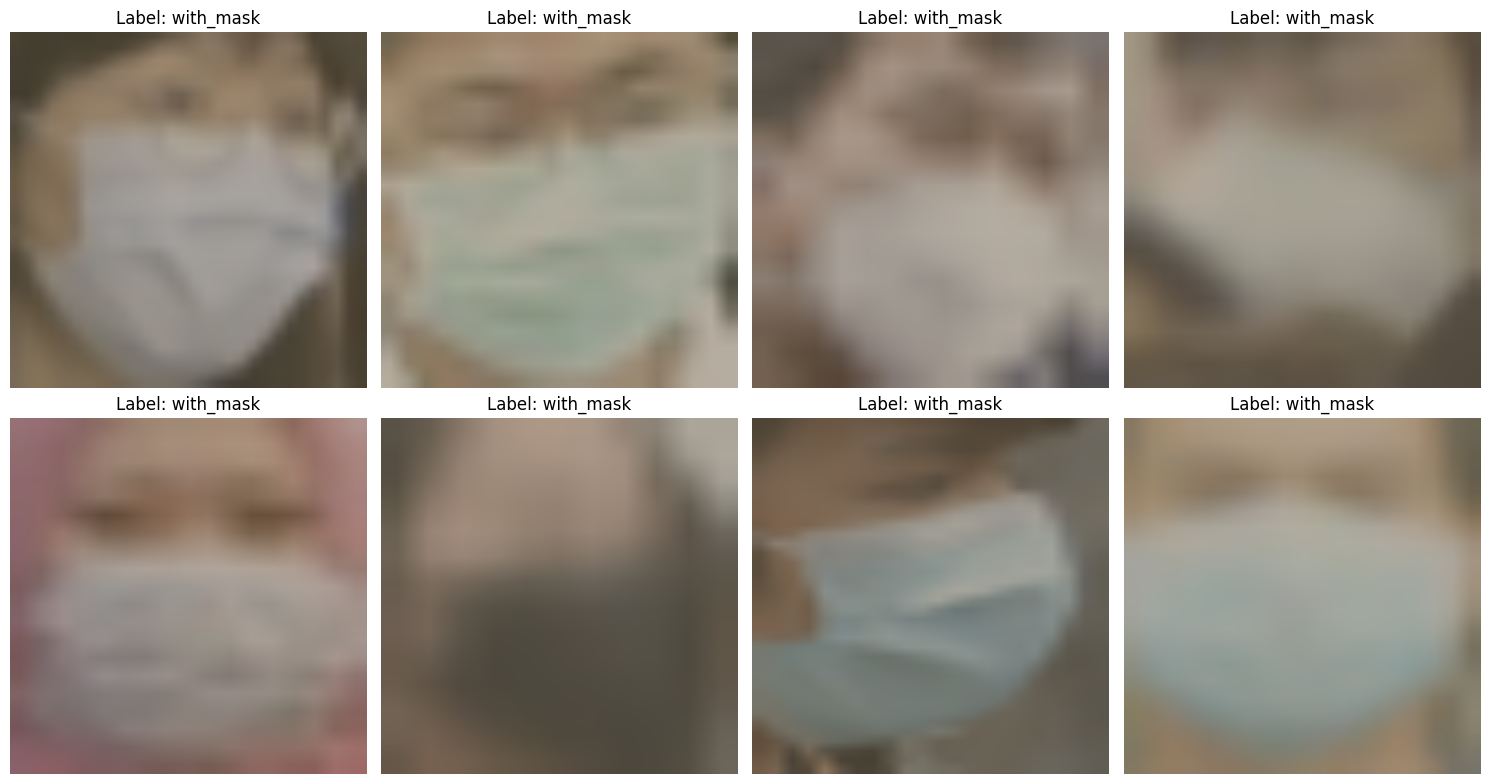

In [7]:
# Visualize một số ảnh sau augmentation
def plot_augmented_images(images, labels, num_samples=8):
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    axes = axes.ravel()

    for i in range(num_samples):
        # Denormalize image để hiển thị
        img = images[i].copy()
        img = (img * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
        img = np.clip(img, 0, 1)

        axes[i].imshow(img)
        label_text = lb.classes_[np.argmax(labels[i])]
        axes[i].set_title(f'Label: {label_text}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Hiển thị một số sample
plot_augmented_images(trainX[:8], trainY[:8])

In [8]:
# Rebuild model với improved architecture
print("[INFO] Building improved model...")

# Base model
baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))

# Improved head model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.4)(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.3)(headModel)
headModel = Dense(len(lb.classes_), activation="softmax")(headModel)

# Create model
improved_model = Model(inputs=baseModel.input, outputs=headModel)

# Freeze base model layers
for layer in baseModel.layers:
    layer.trainable = False

# Compile với class weights
print("[INFO] Compiling improved model with class weights...")
opt = Adam(learning_rate=INIT_LR)
improved_model.compile(
    loss="categorical_crossentropy",
    optimizer=opt,
    metrics=["accuracy"]
)

[INFO] Building improved model...


<ipython-input-8-2451455184>:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  baseModel = MobileNetV2(weights="imagenet", include_top=False,


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
[INFO] Compiling improved model with class weights...


In [10]:
# Định nghĩa aug ở global scope
print("[INFO] Creating global data augmentation generator...")

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Tạo global data augmentation generator cho training
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode="nearest"
)

print("[INFO] Global data augmentation generator created successfully!")

# Kiểm tra các biến cần thiết
print(f"\n[INFO] Checking required variables:")
try:
    print(f"  trainX shape: {trainX.shape}")
    print(f"  trainY shape: {trainY.shape}")
    print(f"  testX shape: {testX.shape}")
    print(f"  testY shape: {testY.shape}")
    print(f"  Batch size (BS): {BS}")
    print(f"  Image size: {IMAGE_SIZE}")
    print(f"  Classes: {lb.classes_}")
    print(f"  Number of classes: {len(lb.classes_)}")
    print(f"  Learning rate (INIT_LR): {INIT_LR}")
    print(f"  Epochs: {EPOCHS}")
except NameError as e:
    print(f" Missing variable: {e}")
    print("  Please run the previous cells to define missing variables")

# Test data augmentation
print(f"\n[INFO] Testing data augmentation...")
try:
    # Test với 1 sample
    test_batch = aug.flow(trainX[:2], trainY[:2], batch_size=2)
    test_sample = next(test_batch)
    print(f"  Augmentation test successful!")
    print(f"     - Input shape: {test_sample[0].shape}")
    print(f"     - Output shape: {test_sample[1].shape}")
except Exception as e:
    print(f"  Augmentation test failed: {e}")

[INFO] Creating global data augmentation generator...
[INFO] Global data augmentation generator created successfully!

[INFO] Checking required variables:
  trainX shape: (3319, 224, 224, 3)
  trainY shape: (3319, 3)
  testX shape: (830, 224, 224, 3)
  testY shape: (830, 3)
  Batch size (BS): 32
  Image size: 224
  Classes: ['mask_weared_incorrect' 'with_mask' 'without_mask']
  Number of classes: 3
  Learning rate (INIT_LR): 0.0001
  Epochs: 20

[INFO] Testing data augmentation...
  Augmentation test successful!
     - Input shape: (2, 224, 224, 3)
     - Output shape: (2, 3)


In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


# Callbacks
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-7, verbose=1),
    ModelCheckpoint('improved_mask_detector.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
]

# Training với class weights
print("[INFO] Training improved model with class weights...")
H_improved = improved_model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=class_weight_dict,  # Sử dụng class weights
    verbose=1
)

# Load best model
improved_model = tf.keras.models.load_model('improved_mask_detector.h5')

# Update global model
model = improved_model

print("[INFO] Improved model training completed!")

# Đánh giá model
print("[INFO] Evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)

# Classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
    target_names=lb.classes_))

# Lưu model và label encoder
print("[INFO] Saving mask detector model...")
model.save("/content/drive/MyDrive/mask_detector.h5", save_format="h5")

# Lưu label binarizer
with open("/content/drive/MyDrive/lb.pickle", "wb") as f:
    f.write(pickle.dumps(lb))

print("[INFO] Model saved to Google Drive!")

[INFO] Training improved model with class weights...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - accuracy: 0.5174 - loss: 1.8487
Epoch 1: val_accuracy improved from -inf to 0.36265, saving model to improved_mask_detector.h5


103/103 ━━━━━━━━━━━━━━━━━━━━ 86s 686ms/step - accuracy: 0.5169 - loss: 1.8462 - val_accuracy: 0.3627 - val_loss: 1.0888 - learning_rate: 1.0000e-04
Epoch 2/20
  1/103 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.4375 - loss: 0.6059

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.36265 to 0.36506, saving model to improved_mask_detector.h5


103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.4375 - loss: 0.6059 - val_accuracy: 0.3651 - val_loss: 1.0898 - learning_rate: 1.0000e-04
Epoch 3/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - accuracy: 0.4239 - loss: 1.3077
Epoch 3: val_accuracy improved from 0.36506 to 0.47590, saving model to improved_mask_detector.h5


103/103 ━━━━━━━━━━━━━━━━━━━━ 52s 505ms/step - accuracy: 0.4239 - loss: 1.3076 - val_accuracy: 0.4759 - val_loss: 1.0299 - learning_rate: 1.0000e-04
Epoch 4/20
  1/103 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.4688 - loss: 2.1379
Epoch 4: val_accuracy did not improve from 0.47590
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4688 - loss: 2.1379 - val_accuracy: 0.4759 - val_loss: 1.0290 - learning_rate: 1.0000e-04
Epoch 5/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.4636 - loss: 1.0657
Epoch 5: val_accuracy improved from 0.47590 to 0.48193, saving model to improved_mask_detector.h5


103/103 ━━━━━━━━━━━━━━━━━━━━ 50s 483ms/step - accuracy: 0.4637 - loss: 1.0660 - val_accuracy: 0.4819 - val_loss: 0.9662 - learning_rate: 1.0000e-04
Epoch 6/20
  1/103 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.5938 - loss: 0.9290
Epoch 6: val_accuracy improved from 0.48193 to 0.48675, saving model to improved_mask_detector.h5


103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5938 - loss: 0.9290 - val_accuracy: 0.4867 - val_loss: 0.9635 - learning_rate: 1.0000e-04
Epoch 7/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 0.4966 - loss: 1.1155
Epoch 7: val_accuracy improved from 0.48675 to 0.59880, saving model to improved_mask_detector.h5


103/103 ━━━━━━━━━━━━━━━━━━━━ 83s 506ms/step - accuracy: 0.4967 - loss: 1.1153 - val_accuracy: 0.5988 - val_loss: 0.9174 - learning_rate: 1.0000e-04
Epoch 8/20
  1/103 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.5938 - loss: 0.8826
Epoch 8: val_accuracy did not improve from 0.59880
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5938 - loss: 0.8826 - val_accuracy: 0.5976 - val_loss: 0.9194 - learning_rate: 1.0000e-04
Epoch 9/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.4919 - loss: 1.0282
Epoch 9: val_accuracy improved from 0.59880 to 0.71687, saving model to improved_mask_detector.h5


103/103 ━━━━━━━━━━━━━━━━━━━━ 52s 501ms/step - accuracy: 0.4921 - loss: 1.0283 - val_accuracy: 0.7169 - val_loss: 0.7895 - learning_rate: 1.0000e-04
Epoch 10/20
  1/103 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.5938 - loss: 1.2422
Epoch 10: val_accuracy did not improve from 0.71687
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5938 - loss: 1.2422 - val_accuracy: 0.7145 - val_loss: 0.7901 - learning_rate: 1.0000e-04
Epoch 11/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.5468 - loss: 0.9341
Epoch 11: val_accuracy did not improve from 0.71687
103/103 ━━━━━━━━━━━━━━━━━━━━ 82s 512ms/step - accuracy: 0.5468 - loss: 0.9346 - val_accuracy: 0.7036 - val_loss: 0.7803 - learning_rate: 1.0000e-04
Epoch 12/20
  1/103 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.3125 - loss: 0.5976
Epoch 12: val_accuracy did not improve from 0.71687
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3125 - loss: 0.5976 - val_accuracy: 0.7036 - val_loss: 0.7811 - learning_rate: 1.00

103/103 ━━━━━━━━━━━━━━━━━━━━ 83s 503ms/step - accuracy: 0.5679 - loss: 0.9175 - val_accuracy: 0.7181 - val_loss: 0.7155 - learning_rate: 1.0000e-04
Epoch 16/20
  1/103 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.4688 - loss: 0.5673
Epoch 16: val_accuracy did not improve from 0.71807
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4688 - loss: 0.5673 - val_accuracy: 0.7181 - val_loss: 0.7155 - learning_rate: 1.0000e-04
Epoch 17/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.5854 - loss: 0.8927
Epoch 17: val_accuracy improved from 0.71807 to 0.76265, saving model to improved_mask_detector.h5


103/103 ━━━━━━━━━━━━━━━━━━━━ 80s 500ms/step - accuracy: 0.5853 - loss: 0.8931 - val_accuracy: 0.7627 - val_loss: 0.6772 - learning_rate: 1.0000e-04
Epoch 18/20
  1/103 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.5000 - loss: 0.5135
Epoch 18: val_accuracy did not improve from 0.76265
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5000 - loss: 0.5135 - val_accuracy: 0.7614 - val_loss: 0.6733 - learning_rate: 1.0000e-04
Epoch 19/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.5854 - loss: 0.9349
Epoch 19: val_accuracy improved from 0.76265 to 0.76747, saving model to improved_mask_detector.h5


103/103 ━━━━━━━━━━━━━━━━━━━━ 52s 510ms/step - accuracy: 0.5855 - loss: 0.9344 - val_accuracy: 0.7675 - val_loss: 0.6404 - learning_rate: 1.0000e-04
Epoch 20/20
  1/103 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.6875 - loss: 1.9615
Epoch 20: val_accuracy did not improve from 0.76747
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6875 - loss: 1.9615 - val_accuracy: 0.7663 - val_loss: 0.6460 - learning_rate: 1.0000e-04


[INFO] Improved model training completed!
[INFO] Evaluating network...
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 247ms/step


                       precision    recall  f1-score   support

mask_weared_incorrect       0.36      0.60      0.45        40
            with_mask       0.97      0.74      0.84       647
         without_mask       0.49      0.94      0.65       143

             accuracy                           0.77       830
            macro avg       0.61      0.76      0.65       830
         weighted avg       0.86      0.77      0.79       830

[INFO] Saving mask detector model...
[INFO] Model saved to Google Drive!


[INFO] Using training history from: H_improved


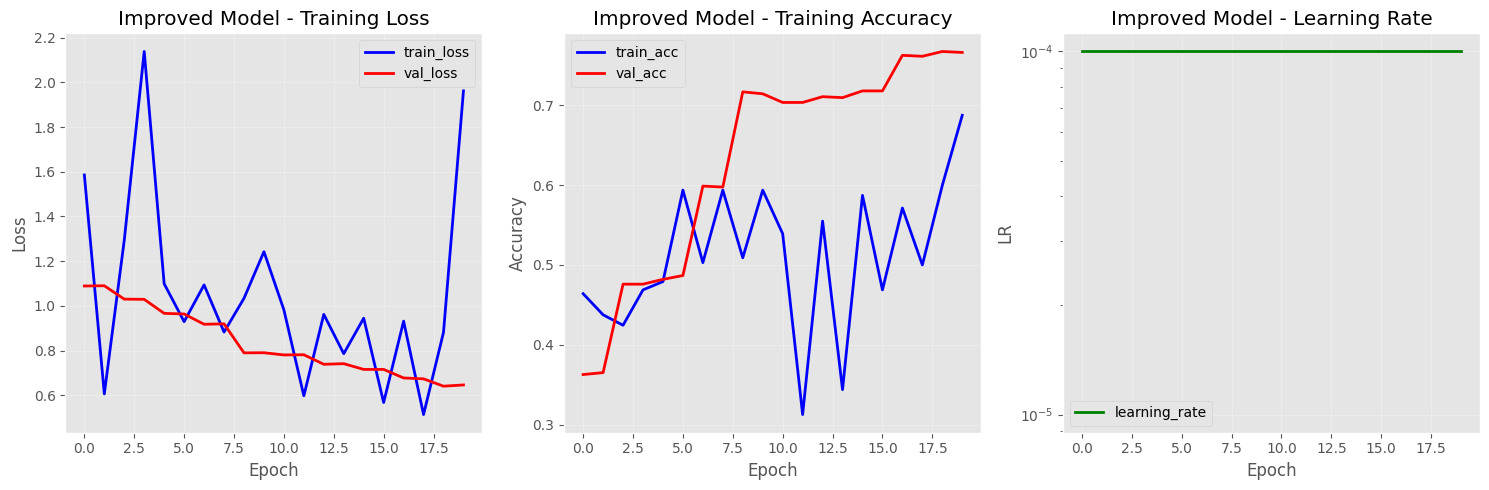


[INFO] Available metrics in training history:
  - accuracy
  - loss
  - val_accuracy
  - val_loss
  - learning_rate

[INFO] Training Statistics:
  • Total epochs completed: 20
  • Final training loss: 1.9615
  • Final validation loss: 0.6460
  • Final training accuracy: 0.6875 (68.75%)
  • Final validation accuracy: 0.7663 (76.63%)
  • Best validation accuracy: 0.7675 (76.75%) at epoch 19
  Good: Validation accuracy >= training accuracy


In [13]:
# Vẽ training history với biến đúng
plt.style.use("ggplot")
plt.figure(figsize=(15, 5))

# Kiểm tra xem có history không
if 'H_improved' in globals() and H_improved is not None:
    history = H_improved
    title_prefix = "Improved Model - "
elif 'H' in globals() and H is not None:
    history = H
    title_prefix = "Original Model - "
else:
    print("[ERROR] No training history found!")
    print("Please make sure model training completed successfully")
    # Tạo dummy plot
    plt.figure(figsize=(15, 5))
    plt.text(0.5, 0.5, 'No Training History Available',
             horizontalalignment='center', verticalalignment='center',
             transform=plt.gca().transAxes, fontsize=16)
    plt.show()
    exit()

print(f"[INFO] Using training history from: {'H_improved' if 'H_improved' in globals() and H_improved is not None else 'H'}")

# Plot 1: Training Loss
plt.subplot(1, 3, 1)
plt.plot(history.history["loss"], label="train_loss", color='blue', linewidth=2)
plt.plot(history.history["val_loss"], label="val_loss", color='red', linewidth=2)
plt.title(f"{title_prefix}Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Training Accuracy
plt.subplot(1, 3, 2)
plt.plot(history.history["accuracy"], label="train_acc", color='blue', linewidth=2)
plt.plot(history.history["val_accuracy"], label="val_acc", color='red', linewidth=2)
plt.title(f"{title_prefix}Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Learning Rate hoặc Validation Accuracy
plt.subplot(1, 3, 3)
if "lr" in history.history:
    plt.plot(history.history["lr"], label="learning_rate", color='green', linewidth=2)
    plt.title(f"{title_prefix}Learning Rate")
    plt.xlabel("Epoch")
    plt.ylabel("LR")
    plt.yscale('log')  # Log scale cho learning rate
    plt.legend()
    plt.grid(True, alpha=0.3)
elif "learning_rate" in history.history:
    plt.plot(history.history["learning_rate"], label="learning_rate", color='green', linewidth=2)
    plt.title(f"{title_prefix}Learning Rate")
    plt.xlabel("Epoch")
    plt.ylabel("LR")
    plt.yscale('log')  # Log scale cho learning rate
    plt.legend()
    plt.grid(True, alpha=0.3)
else:
    # Nếu không có LR history, vẽ validation accuracy với màu khác
    plt.plot(history.history["val_accuracy"], label="val_accuracy", color='orange', linewidth=2)
    plt.title(f"{title_prefix}Validation Accuracy Detail")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True, alpha=0.3)
    print("[INFO] Learning rate history not available, showing validation accuracy instead")

plt.tight_layout()
plt.show()

# In ra các keys có sẵn trong history
print(f"\n[INFO] Available metrics in training history:")
for key in history.history.keys():
    print(f"  - {key}")

# In thống kê chi tiết
print(f"\n[INFO] Training Statistics:")
print(f"  • Total epochs completed: {len(history.history['loss'])}")

if len(history.history['loss']) > 0:
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]

    best_val_acc = max(history.history['val_accuracy'])
    best_val_acc_epoch = history.history['val_accuracy'].index(best_val_acc) + 1

    print(f"  • Final training loss: {final_train_loss:.4f}")
    print(f"  • Final validation loss: {final_val_loss:.4f}")
    print(f"  • Final training accuracy: {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
    print(f"  • Final validation accuracy: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")
    print(f"  • Best validation accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%) at epoch {best_val_acc_epoch}")

    # Kiểm tra overfitting
    if final_train_acc - final_val_acc > 0.1:
        print("  Warning: Possible overfitting detected (train acc >> val acc)")
    elif final_val_acc > final_train_acc:
        print("  Good: Validation accuracy >= training accuracy")
    else:
        print("  Training looks healthy")

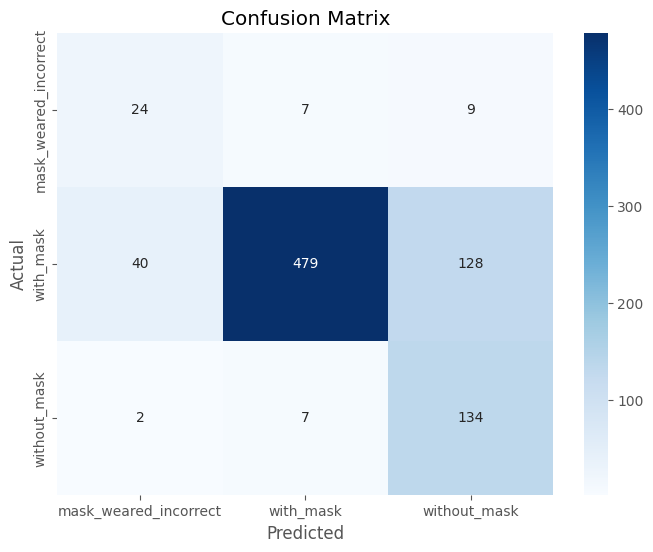

In [14]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=lb.classes_, yticklabels=lb.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [16]:
# Load model đã train từ Google Drive
print("[INFO] Loading trained model...")
model = tf.keras.models.load_model("/content/drive/MyDrive/mask_detector.h5")

# Load label binarizer
with open("/content/drive/MyDrive/lb.pickle", "rb") as f:
    lb = pickle.loads(f.read())

# Download face detector DNN model
print("[INFO] Loading face detector...")
!wget -q -O deploy.prototxt https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
!wget -q -O res10_300x300_ssd_iter_140000.caffemodel https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel

net = cv2.dnn.readNet("deploy.prototxt", "res10_300x300_ssd_iter_140000.caffemodel")

def detect_and_predict_mask(frame, faceNet, maskNet, confidence_threshold=0.5):
    """Detect faces và predict mask - cập nhật cho 3 classes"""
    (h, w) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300), (104.0, 177.0, 123.0))

    faceNet.setInput(blob)
    detections = faceNet.forward()

    faces = []
    locs = []
    preds = []

    for i in range(0, detections.shape[2]):
        confidence = detections[0, 0, i, 2]

        if confidence > confidence_threshold:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")

            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))

            if startX < endX and startY < endY:
                face = frame[startY:endY, startX:endX]
                face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
                face = cv2.resize(face, (IMAGE_SIZE, IMAGE_SIZE))
                face = img_to_array(face)
                face = preprocess_input(face)

                faces.append(face)
                locs.append((startX, startY, endX, endY))

    if len(faces) > 0:
        faces = np.array(faces, dtype="float32")
        preds = maskNet.predict(faces, batch_size=32)

    return (locs, preds)

# Cập nhật visualization function cho 3 classes
def get_label_color(class_name):
    """Trả về màu và text cho từng class"""
    if class_name == "with_mask":
        return (0, 255, 0), "Mask"  # Xanh lá
    elif class_name == "without_mask":
        return (0, 0, 255), "No Mask"  # Đỏ
    elif class_name == "mask_weared_incorrect":
        return (0, 165, 255), "Incorrect Mask"  # Cam
    else:
        return (128, 128, 128), "Unknown"  # Xám

print("[INFO] Detection functions updated for 3 classes")

[INFO] Loading trained model...


[INFO] Loading face detector...
[INFO] Detection functions updated for 3 classes


✅ Google Colab modules imported successfully!


🎭 [INFO] Webcam Face Mask Detection đã sẵn sàng!
📋 Hướng dẫn sử dụng:
   1. Cho phép truy cập webcam khi browser yêu cầu
   2. Điều chỉnh vị trí để khuôn mặt hiển thị rõ ràng trong khung hình
   3. Nhấn nút '📸 Chụp ảnh và phân tích khẩu trang'
   4. Xem kết quả phân tích chi tiết bên dưới
   5. Có thể chụp nhiều lần để test các trường hợp khác nhau

🤖 Thông tin model:
   • Architecture: SSD-MobileNetV2
   • Classes: mask_weared_incorrect, with_mask, without_mask
   • Input size: 224x224 pixels
🔍 [INFO] Bắt đầu phân tích ảnh...
📏 [INFO] Kích thước ảnh: (480, 640, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
👤 [INFO] Phát hiện 1 khuôn mặt


<ipython-input-23-2322154576>:184: UserWarning: Glyph 128248 (\N{CAMERA WITH FLASH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-23-2322154576>:184: UserWarning: Glyph 127917 (\N{PERFORMING ARTS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


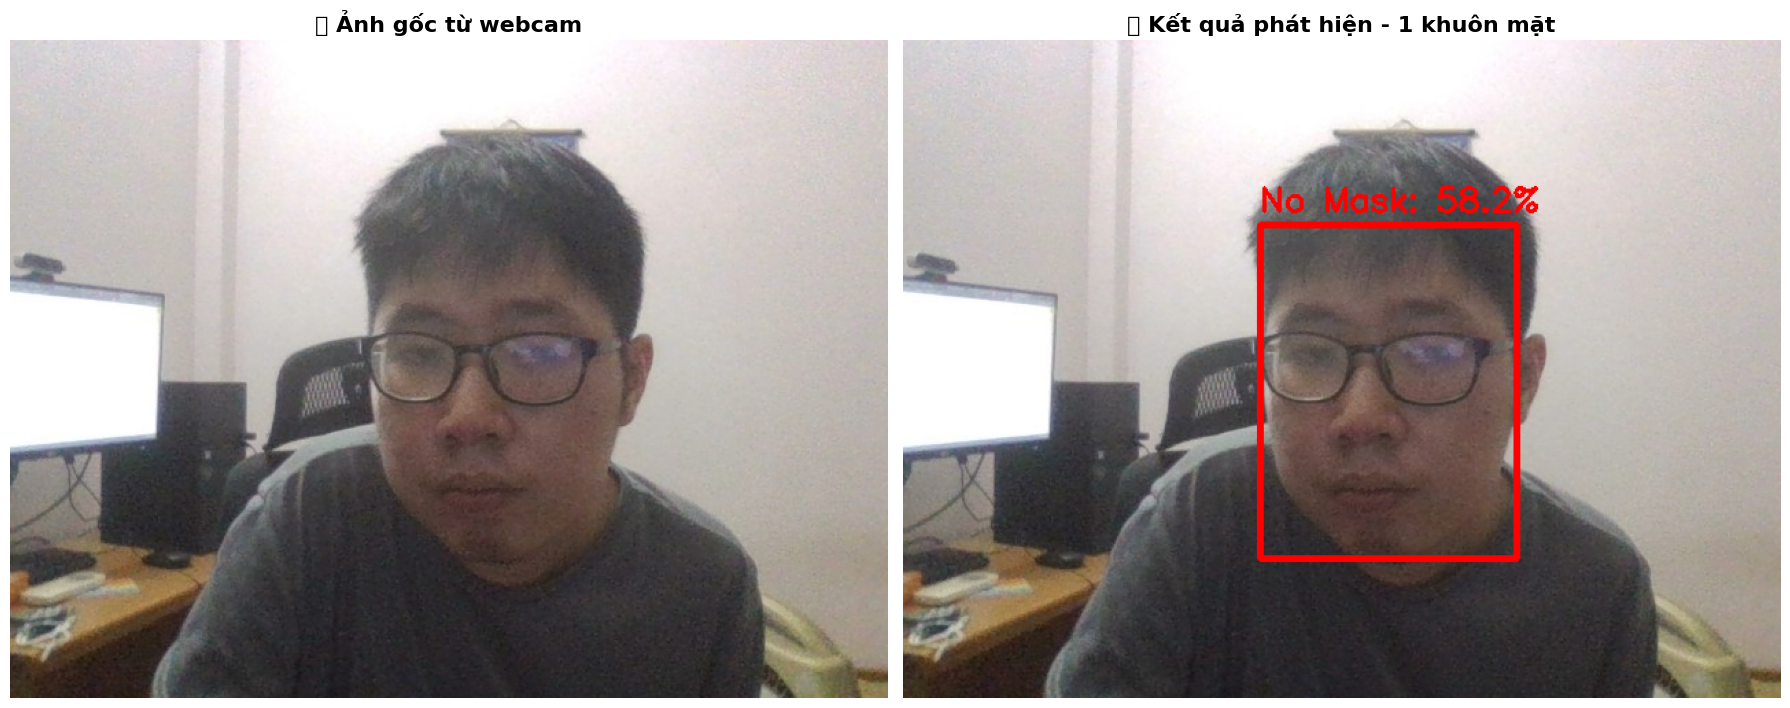


🎭 KẾT QUẢ PHÁT HIỆN KHẨU TRANG
📊 Tổng số khuôn mặt phát hiện: 1
🤖 Model được sử dụng: SSD-MobileNetV2
📅 Thời gian phân tích: 2025-06-13 09:31:49

👤 --- KHUÔN MẶT 1 ---
🏷️  Phân loại: without_mask
🎯 Độ tin cậy: 58.2%
📍 Vị trí (x1,y1,x2,y2): (np.int64(260), np.int64(135), np.int64(447), np.int64(378))
📊 Chi tiết xác suất cho tất cả các lớp:
   ✅ without_mask: 58.25%
   ⚪ with_mask: 21.58%
   ⚪ mask_weared_incorrect: 20.17%

📈 THỐNG KÊ TỔNG KẾT:
──────────────────────────────────────────────────
• without_mask: 1 người (100.0%)

🎯 ĐỘ TIN CẬY TRUNG BÌNH: 58.2%

🏥 ĐÁNH GIÁ TUÂN THỦ KHẨU TRANG:
──────────────────────────────────────────────────
❌ KÉMM: 0.0% tuân thủ đeo khẩu trang
🔍 [INFO] Bắt đầu phân tích ảnh...
📏 [INFO] Kích thước ảnh: (480, 640, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
👤 [INFO] Phát hiện 1 khuôn mặt


<ipython-input-23-2322154576>:184: UserWarning: Glyph 128248 (\N{CAMERA WITH FLASH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-23-2322154576>:184: UserWarning: Glyph 127917 (\N{PERFORMING ARTS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


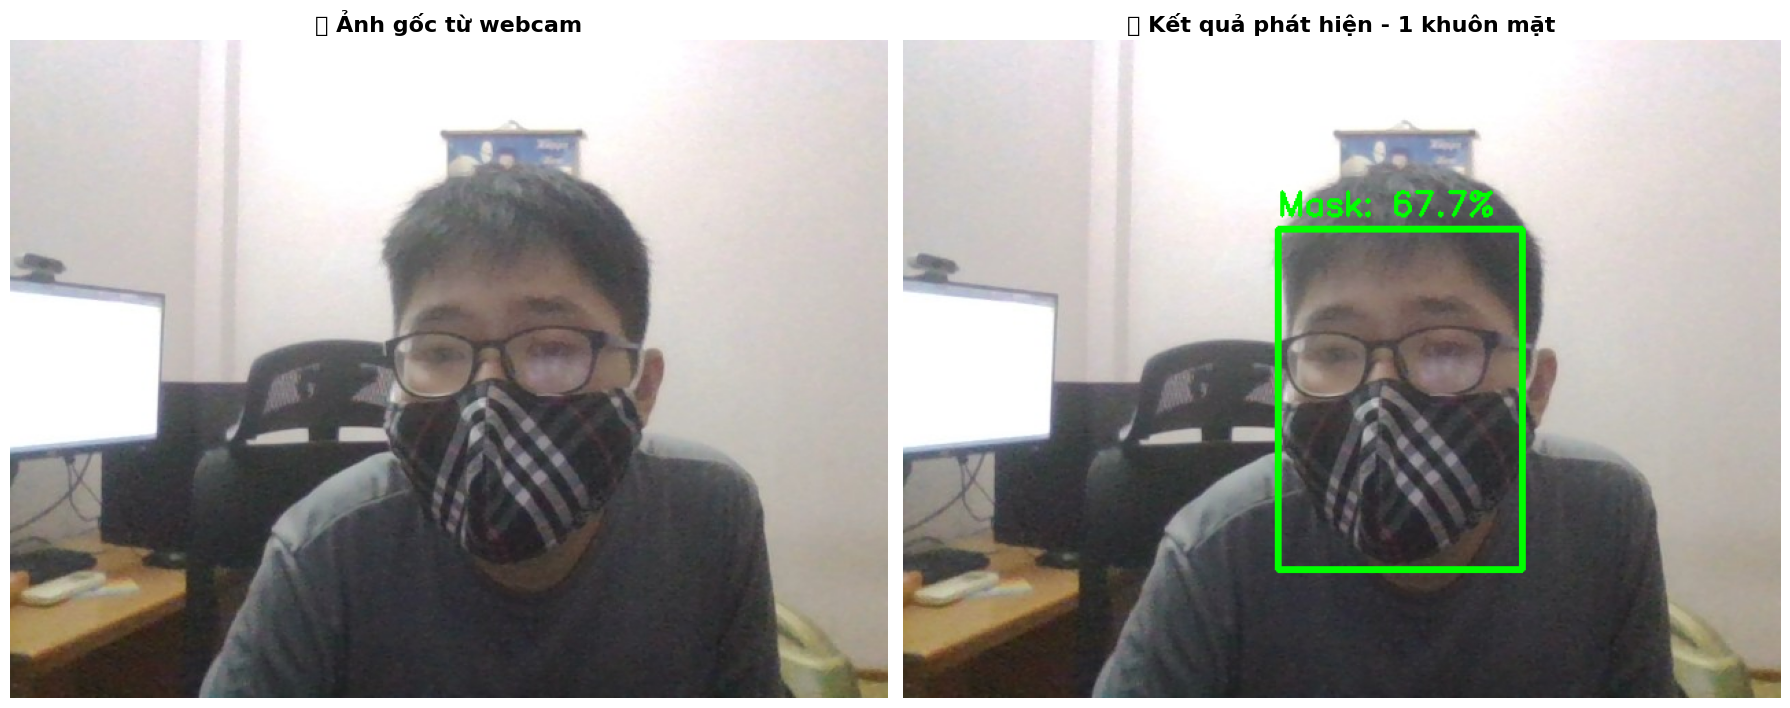


🎭 KẾT QUẢ PHÁT HIỆN KHẨU TRANG
📊 Tổng số khuôn mặt phát hiện: 1
🤖 Model được sử dụng: SSD-MobileNetV2
📅 Thời gian phân tích: 2025-06-13 09:32:19

👤 --- KHUÔN MẶT 1 ---
🏷️  Phân loại: with_mask
🎯 Độ tin cậy: 67.7%
📍 Vị trí (x1,y1,x2,y2): (np.int64(273), np.int64(138), np.int64(451), np.int64(386))
📊 Chi tiết xác suất cho tất cả các lớp:
   ✅ with_mask: 67.69%
   ⚪ mask_weared_incorrect: 26.56%
   ⚪ without_mask: 5.76%

📈 THỐNG KÊ TỔNG KẾT:
──────────────────────────────────────────────────
• with_mask: 1 người (100.0%)

🎯 ĐỘ TIN CẬY TRUNG BÌNH: 67.7%

🏥 ĐÁNH GIÁ TUÂN THỦ KHẨU TRANG:
──────────────────────────────────────────────────
✅ XUẤT SẮC: 100.0% tuân thủ đeo khẩu trang
🔍 [INFO] Bắt đầu phân tích ảnh...
📏 [INFO] Kích thước ảnh: (480, 640, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
👤 [INFO] Phát hiện 1 khuôn mặt


<ipython-input-23-2322154576>:184: UserWarning: Glyph 128248 (\N{CAMERA WITH FLASH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-23-2322154576>:184: UserWarning: Glyph 127917 (\N{PERFORMING ARTS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


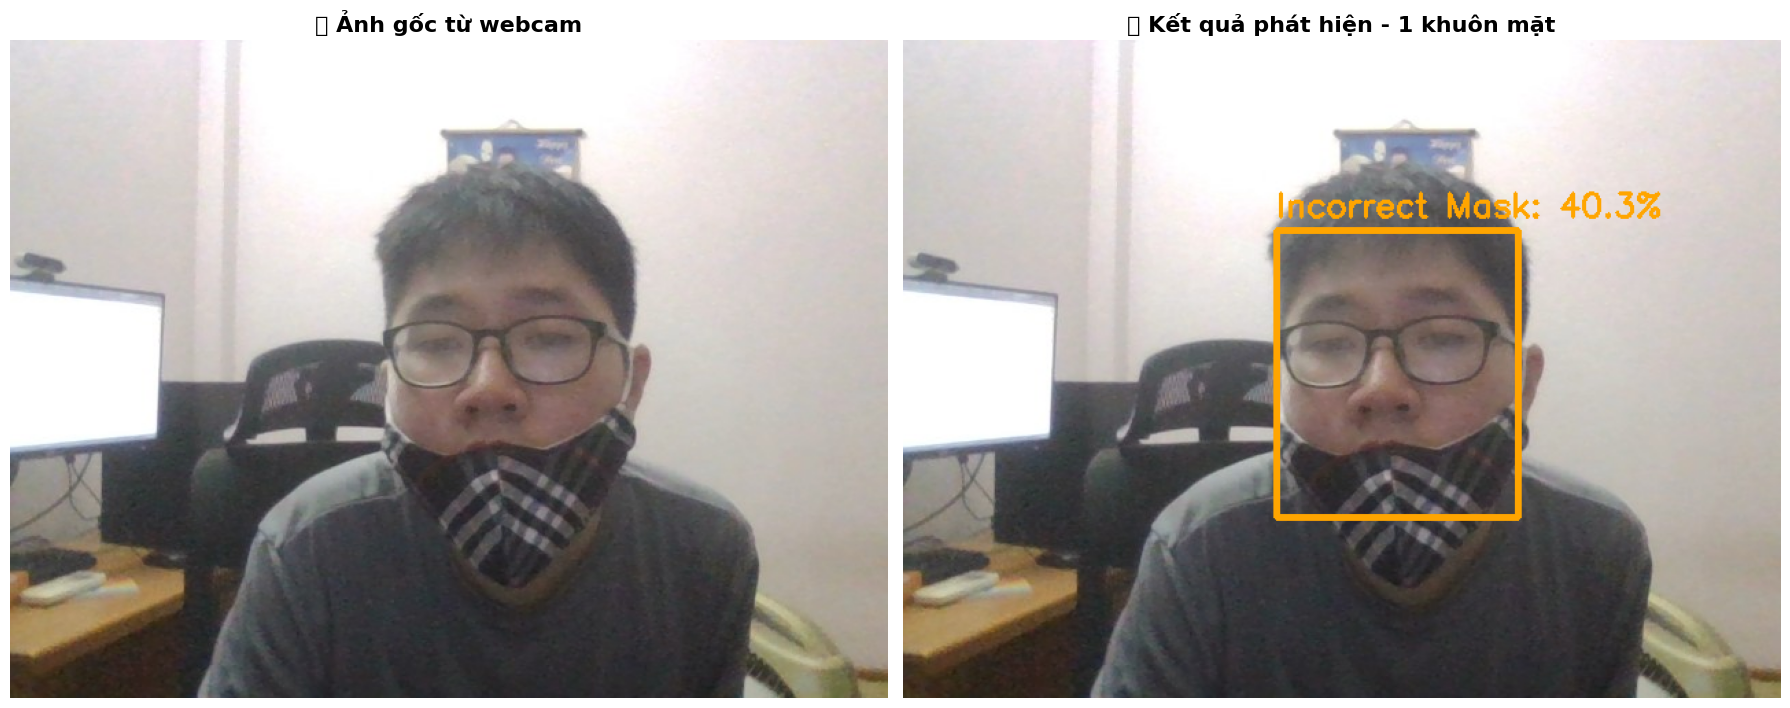


🎭 KẾT QUẢ PHÁT HIỆN KHẨU TRANG
📊 Tổng số khuôn mặt phát hiện: 1
🤖 Model được sử dụng: SSD-MobileNetV2
📅 Thời gian phân tích: 2025-06-13 09:32:40

👤 --- KHUÔN MẶT 1 ---
🏷️  Phân loại: mask_weared_incorrect
🎯 Độ tin cậy: 40.3%
📍 Vị trí (x1,y1,x2,y2): (np.int64(272), np.int64(139), np.int64(448), np.int64(348))
📊 Chi tiết xác suất cho tất cả các lớp:
   ✅ mask_weared_incorrect: 40.33%
   ⚪ without_mask: 36.62%
   ⚪ with_mask: 23.05%

📈 THỐNG KÊ TỔNG KẾT:
──────────────────────────────────────────────────
• mask_weared_incorrect: 1 người (100.0%)

🎯 ĐỘ TIN CẬY TRUNG BÌNH: 40.3%

🏥 ĐÁNH GIÁ TUÂN THỦ KHẨU TRANG:
──────────────────────────────────────────────────
❌ KÉMM: 0.0% tuân thủ đeo khẩu trang
🔍 [INFO] Bắt đầu phân tích ảnh...
📏 [INFO] Kích thước ảnh: (480, 640, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
👤 [INFO] Phát hiện 1 khuôn mặt


<ipython-input-23-2322154576>:184: UserWarning: Glyph 128248 (\N{CAMERA WITH FLASH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-23-2322154576>:184: UserWarning: Glyph 127917 (\N{PERFORMING ARTS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


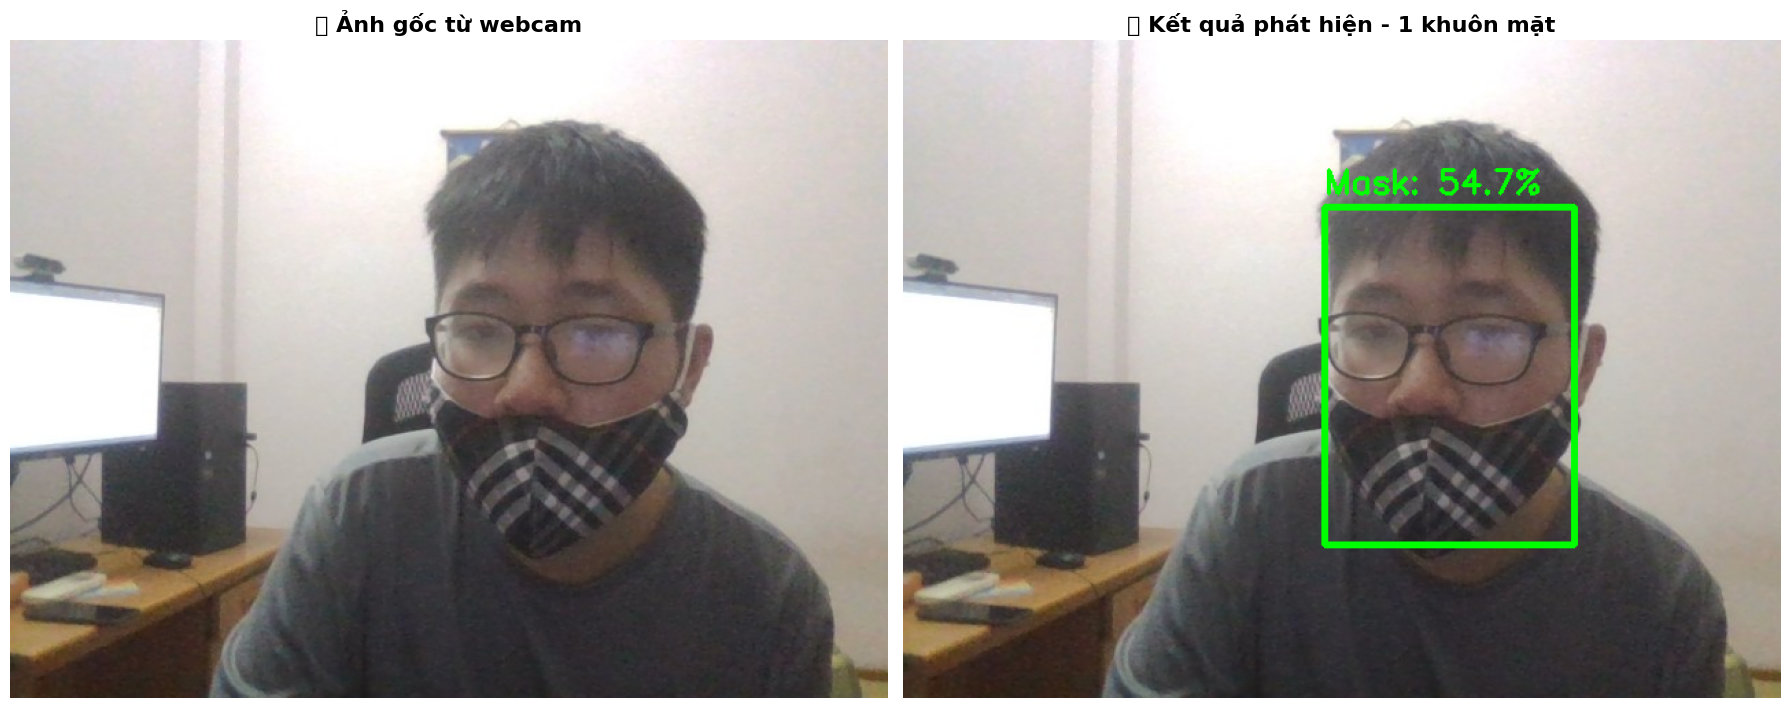


🎭 KẾT QUẢ PHÁT HIỆN KHẨU TRANG
📊 Tổng số khuôn mặt phát hiện: 1
🤖 Model được sử dụng: SSD-MobileNetV2
📅 Thời gian phân tích: 2025-06-13 09:34:40

👤 --- KHUÔN MẶT 1 ---
🏷️  Phân loại: with_mask
🎯 Độ tin cậy: 54.7%
📍 Vị trí (x1,y1,x2,y2): (np.int64(307), np.int64(122), np.int64(489), np.int64(368))
📊 Chi tiết xác suất cho tất cả các lớp:
   ✅ with_mask: 54.69%
   ⚪ mask_weared_incorrect: 31.43%
   ⚪ without_mask: 13.89%

📈 THỐNG KÊ TỔNG KẾT:
──────────────────────────────────────────────────
• with_mask: 1 người (100.0%)

🎯 ĐỘ TIN CẬY TRUNG BÌNH: 54.7%

🏥 ĐÁNH GIÁ TUÂN THỦ KHẨU TRANG:
──────────────────────────────────────────────────
✅ XUẤT SẮC: 100.0% tuân thủ đeo khẩu trang
🔍 [INFO] Bắt đầu phân tích ảnh...
📏 [INFO] Kích thước ảnh: (480, 640, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
👤 [INFO] Phát hiện 1 khuôn mặt


<ipython-input-23-2322154576>:184: UserWarning: Glyph 128248 (\N{CAMERA WITH FLASH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-23-2322154576>:184: UserWarning: Glyph 127917 (\N{PERFORMING ARTS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


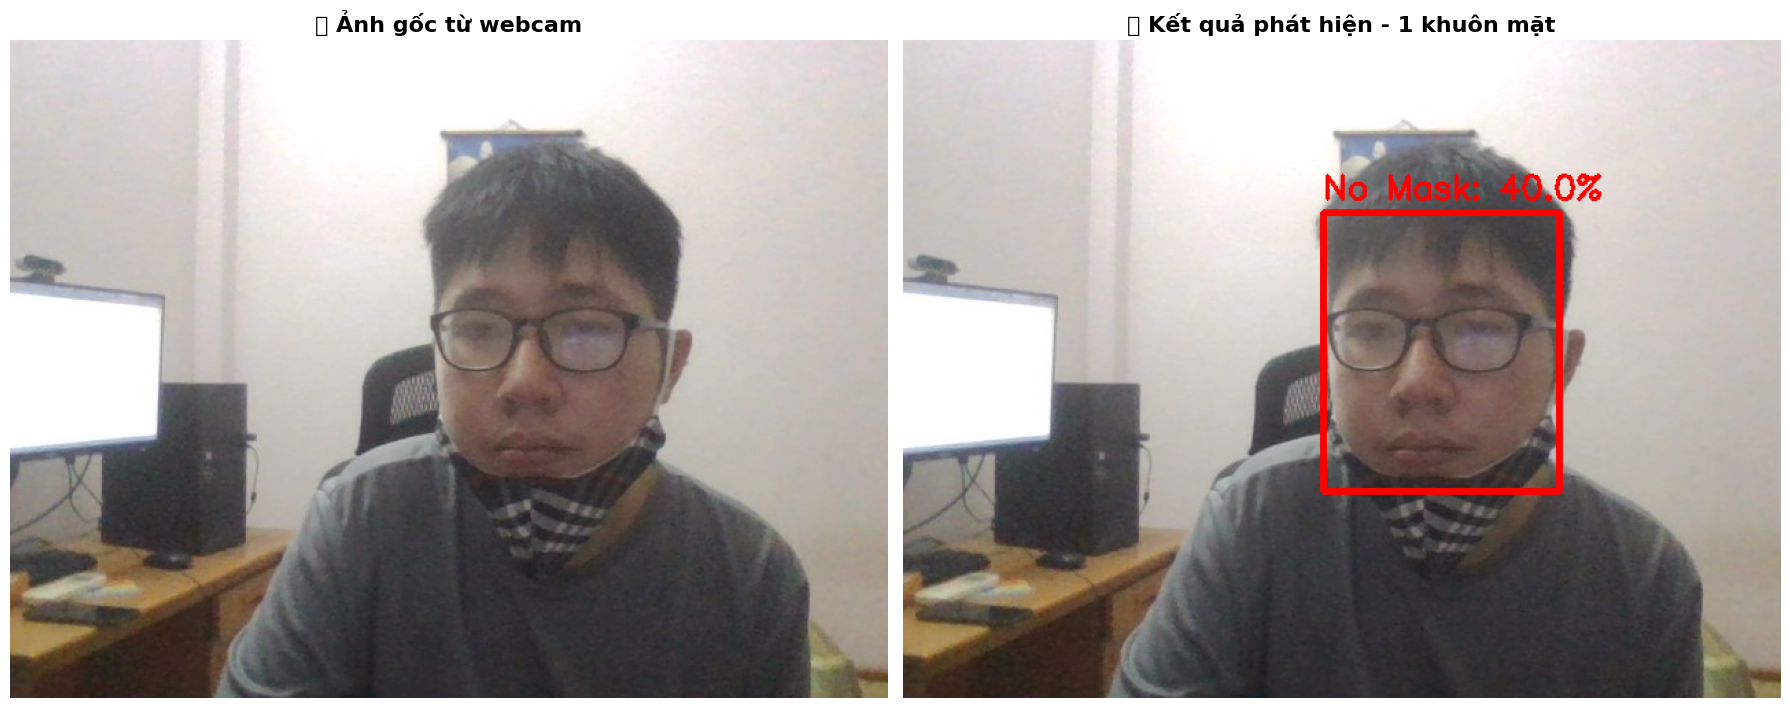


🎭 KẾT QUẢ PHÁT HIỆN KHẨU TRANG
📊 Tổng số khuôn mặt phát hiện: 1
🤖 Model được sử dụng: SSD-MobileNetV2
📅 Thời gian phân tích: 2025-06-13 09:35:10

👤 --- KHUÔN MẶT 1 ---
🏷️  Phân loại: without_mask
🎯 Độ tin cậy: 40.0%
📍 Vị trí (x1,y1,x2,y2): (np.int64(306), np.int64(126), np.int64(478), np.int64(329))
📊 Chi tiết xác suất cho tất cả các lớp:
   ✅ without_mask: 40.00%
   ⚪ mask_weared_incorrect: 31.18%
   ⚪ with_mask: 28.82%

📈 THỐNG KÊ TỔNG KẾT:
──────────────────────────────────────────────────
• without_mask: 1 người (100.0%)

🎯 ĐỘ TIN CẬY TRUNG BÌNH: 40.0%

🏥 ĐÁNH GIÁ TUÂN THỦ KHẨU TRANG:
──────────────────────────────────────────────────
❌ KÉMM: 0.0% tuân thủ đeo khẩu trang
🔍 [INFO] Bắt đầu phân tích ảnh...
📏 [INFO] Kích thước ảnh: (480, 640, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
👤 [INFO] Phát hiện 1 khuôn mặt


<ipython-input-23-2322154576>:184: UserWarning: Glyph 128248 (\N{CAMERA WITH FLASH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-23-2322154576>:184: UserWarning: Glyph 127917 (\N{PERFORMING ARTS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


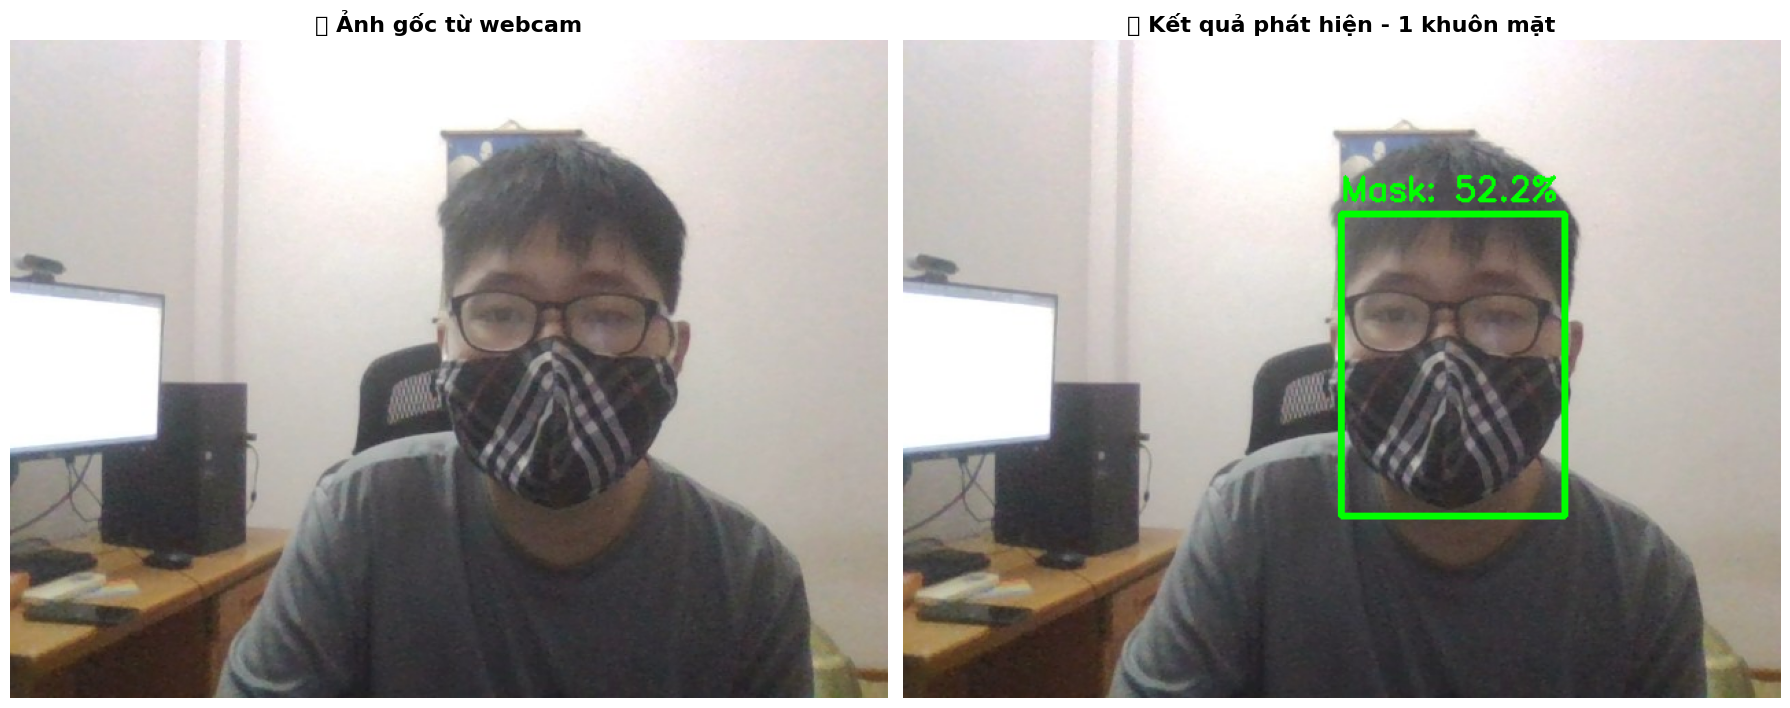


🎭 KẾT QUẢ PHÁT HIỆN KHẨU TRANG
📊 Tổng số khuôn mặt phát hiện: 1
🤖 Model được sử dụng: SSD-MobileNetV2
📅 Thời gian phân tích: 2025-06-13 09:35:30

👤 --- KHUÔN MẶT 1 ---
🏷️  Phân loại: with_mask
🎯 Độ tin cậy: 52.2%
📍 Vị trí (x1,y1,x2,y2): (np.int64(319), np.int64(127), np.int64(482), np.int64(347))
📊 Chi tiết xác suất cho tất cả các lớp:
   ✅ with_mask: 52.24%
   ⚪ mask_weared_incorrect: 40.43%
   ⚪ without_mask: 7.32%

📈 THỐNG KÊ TỔNG KẾT:
──────────────────────────────────────────────────
• with_mask: 1 người (100.0%)

🎯 ĐỘ TIN CẬY TRUNG BÌNH: 52.2%

🏥 ĐÁNH GIÁ TUÂN THỦ KHẨU TRANG:
──────────────────────────────────────────────────
✅ XUẤT SẮC: 100.0% tuân thủ đeo khẩu trang


In [23]:
from IPython.display import display, Javascript, HTML
try:
    import google.colab.output
    from google.colab import files
    from IPython.display import display, HTML, Javascript
    print("✅ Google Colab modules imported successfully!")
except ImportError as e:
    print(f"❌ Failed to import Google Colab modules: {e}")
    print("Note: This code is designed to run in Google Colab environment")
from datetime import datetime as dt
from base64 import b64decode
import PIL.Image
import io
import numpy as np
import cv2
import matplotlib.pyplot as plt

def simple_webcam_capture():
    """Webcam capture đơn giản - chỉ chụp 1 ảnh (sử dụng functions có sẵn)"""

    html_code = """
    <div style="text-align: center; margin: 20px; padding: 20px; border: 2px solid #333; border-radius: 15px; background-color: #f9f9f9;">
        <h2 style="color: #333;">🎭 Face Mask Detection</h2>
        <p style="color: #666; font-size: 14px;">Phát hiện khẩu trang với SSD-MobileNetV2</p>
        <video id="video" width="640" height="480" autoplay style="border: 3px solid #007bff; border-radius: 10px; box-shadow: 0 4px 8px rgba(0,0,0,0.1);"></video>
        <br><br>
        <button onclick="captureAndAnalyze()"
                style="padding: 15px 40px; font-size: 20px; font-weight: bold;
                       background: linear-gradient(45deg, #007bff, #0056b3);
                       color: white; border: none; border-radius: 25px;
                       cursor: pointer; box-shadow: 0 4px 8px rgba(0,0,0,0.2);
                       transition: transform 0.2s;">
            📸 Chụp ảnh và phân tích khẩu trang
        </button>
        <br><br>
        <div id="status" style="font-size: 16px; font-weight: bold; color: #007bff;">
            Sẵn sàng chụp ảnh
        </div>
        <div id="info" style="font-size: 12px; color: #888; margin-top: 10px;">
            Hỗ trợ 3 loại: Đeo khẩu trang đúng cách, Không đeo khẩu trang, Đeo khẩu trang sai cách
        </div>
        <canvas id="canvas" width="640" height="480" style="display:none;"></canvas>
    </div>

    <script>
    let video = document.getElementById('video');
    let canvas = document.getElementById('canvas');
    let ctx = canvas.getContext('2d');
    let stream = null;

    // Khởi tạo webcam
    async function initWebcam() {
        try {
            stream = await navigator.mediaDevices.getUserMedia({
                video: {
                    width: { ideal: 640 },
                    height: { ideal: 480 },
                    facingMode: 'user'
                }
            });
            video.srcObject = stream;
            document.getElementById('status').innerHTML = '✅ Webcam đã sẵn sàng - Nhấn nút để chụp ảnh';
            document.getElementById('status').style.color = '#28a745';
        } catch (err) {
            console.error('Error accessing webcam:', err);
            document.getElementById('status').innerHTML = '❌ Lỗi: Không thể truy cập webcam';
            document.getElementById('status').style.color = '#dc3545';
            document.getElementById('info').innerHTML = 'Vui lòng cho phép truy cập webcam và refresh trang';
        }
    }

    // Chụp ảnh và phân tích
    function captureAndAnalyze() {
        if (video.readyState === video.HAVE_ENOUGH_DATA) {
            document.getElementById('status').innerHTML = '⏳ Đang chụp ảnh và phân tích...';
            document.getElementById('status').style.color = '#ffc107';

            ctx.drawImage(video, 0, 0, 640, 480);
            let imageData = canvas.toDataURL('image/jpeg', 0.9);

            // Gửi về Python để phân tích
            google.colab.kernel.invokeFunction('analyze_mask_detection', [imageData], {})
                .then(() => {
                    document.getElementById('status').innerHTML = '✅ Phân tích hoàn tất!';
                    document.getElementById('status').style.color = '#28a745';
                })
                .catch((error) => {
                    document.getElementById('status').innerHTML = '❌ Lỗi khi phân tích';
                    document.getElementById('status').style.color = '#dc3545';
                    console.error('Analysis error:', error);
                });
        } else {
            document.getElementById('status').innerHTML = '⚠️ Webcam chưa sẵn sàng';
            document.getElementById('status').style.color = '#ffc107';
        }
    }

    // Hover effect cho button
    document.addEventListener('DOMContentLoaded', function() {
        const button = document.querySelector('button');
        if (button) {
            button.addEventListener('mouseenter', function() {
                this.style.transform = 'scale(1.05)';
            });
            button.addEventListener('mouseleave', function() {
                this.style.transform = 'scale(1)';
            });
        }
    });

    // Khởi tạo
    initWebcam();
    </script>
    """

    display(HTML(html_code))

    def analyze_mask_detection(image_data):
        """Phân tích ảnh và hiển thị kết quả chi tiết - sử dụng functions có sẵn"""
        try:
            print("🔍 [INFO] Bắt đầu phân tích ảnh...")

            # Decode base64 image
            binary_data = b64decode(image_data.split(',')[1])
            image = PIL.Image.open(io.BytesIO(binary_data))
            frame = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

            print(f"📏 [INFO] Kích thước ảnh: {frame.shape}")

            # Sử dụng function detect_and_predict_mask có sẵn
            (locs, preds) = detect_and_predict_mask(frame, net, model)

            print(f"👤 [INFO] Phát hiện {len(locs)} khuôn mặt")

            # Process results
            result_frame = frame.copy()
            detection_results = []

            for i, (box, pred) in enumerate(zip(locs, preds)):
                (startX, startY, endX, endY) = box

                # Get all class probabilities
                class_probs = {}
                for j, class_name in enumerate(lb.classes_):
                    class_probs[class_name] = pred[j] * 100

                max_idx = np.argmax(pred)
                predicted_class = lb.classes_[max_idx]
                confidence = pred[max_idx] * 100

                # Sử dụng function get_label_color có sẵn
                color, label_text = get_label_color(predicted_class)
                display_text = f"{label_text}: {confidence:.1f}%"

                # Draw on frame
                cv2.putText(result_frame, display_text, (startX, startY - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)
                cv2.rectangle(result_frame, (startX, startY), (endX, endY), color, 3)

                # Store results
                detection_results.append({
                    'face_id': i + 1,
                    'predicted_class': predicted_class,
                    'confidence': confidence,
                    'bbox': (startX, startY, endX, endY),
                    'all_probabilities': class_probs
                })

            # Display results
            plt.figure(figsize=(18, 10))

            # Original image
            plt.subplot(1, 2, 1)
            plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            plt.title("📸 Ảnh gốc từ webcam", fontsize=16, fontweight='bold')
            plt.axis('off')

            # Detection result
            plt.subplot(1, 2, 2)
            plt.imshow(cv2.cvtColor(result_frame, cv2.COLOR_BGR2RGB))
            plt.title(f"🎭 Kết quả phát hiện - {len(locs)} khuôn mặt", fontsize=16, fontweight='bold')
            plt.axis('off')

            plt.tight_layout()
            plt.show()

            # Print detailed results
            print("\n" + "="*80)
            print("🎭 KẾT QUẢ PHÁT HIỆN KHẨU TRANG")
            print("="*80)
            print(f"📊 Tổng số khuôn mặt phát hiện: {len(locs)}")
            print(f"🤖 Model được sử dụng: SSD-MobileNetV2")
            print(f"📅 Thời gian phân tích: {dt.now().strftime('%Y-%m-%d %H:%M:%S')}")

            if len(detection_results) > 0:
                for result in detection_results:
                    print(f"\n👤 --- KHUÔN MẶT {result['face_id']} ---")
                    print(f"🏷️  Phân loại: {result['predicted_class']}")
                    print(f"🎯 Độ tin cậy: {result['confidence']:.1f}%")
                    print(f"📍 Vị trí (x1,y1,x2,y2): {result['bbox']}")
                    print("📊 Chi tiết xác suất cho tất cả các lớp:")

                    # Sort probabilities
                    sorted_probs = sorted(result['all_probabilities'].items(),
                                        key=lambda x: x[1], reverse=True)

                    for class_name, prob in sorted_probs:
                        if class_name == result['predicted_class']:
                            print(f"   ✅ {class_name}: {prob:.2f}%")
                        else:
                            print(f"   ⚪ {class_name}: {prob:.2f}%")

                # Summary statistics
                class_counts = {}
                total_confidence = 0

                for result in detection_results:
                    class_name = result['predicted_class']
                    class_counts[class_name] = class_counts.get(class_name, 0) + 1
                    total_confidence += result['confidence']

                avg_confidence = total_confidence / len(detection_results)

                print(f"\n📈 THỐNG KÊ TỔNG KẾT:")
                print("─"*50)
                for class_name, count in class_counts.items():
                    percentage = (count / len(detection_results)) * 100
                    print(f"• {class_name}: {count} người ({percentage:.1f}%)")

                print(f"\n🎯 ĐỘ TIN CẬY TRUNG BÌNH: {avg_confidence:.1f}%")

                # Health assessment
                with_mask_count = class_counts.get('with_mask', 0)
                total_people = len(detection_results)
                mask_compliance = (with_mask_count / total_people) * 100

                print(f"\n🏥 ĐÁNH GIÁ TUÂN THỦ KHẨU TRANG:")
                print("─"*50)
                if mask_compliance >= 90:
                    print(f"✅ XUẤT SẮC: {mask_compliance:.1f}% tuân thủ đeo khẩu trang")
                elif mask_compliance >= 70:
                    print(f"👍 TỐT: {mask_compliance:.1f}% tuân thủ đeo khẩu trang")
                elif mask_compliance >= 50:
                    print(f"⚠️ TRUNG BÌNH: {mask_compliance:.1f}% tuân thủ đeo khẩu trang")
                else:
                    print(f"❌ KÉMM: {mask_compliance:.1f}% tuân thủ đeo khẩu trang")

            else:
                print("❌ Không phát hiện khuôn mặt nào!")
                print("💡 Gợi ý cải thiện:")
                print("   • Đảm bảo khuôn mặt được chiếu sáng tốt")
                print("   • Nhìn thẳng vào camera")
                print("   • Di chuyển gần camera hơn")
                print("   • Kiểm tra chất lượng webcam")

            print("="*80)

        except Exception as e:
            print(f"❌ Lỗi khi phân tích ảnh: {e}")
            import traceback
            traceback.print_exc()

            # Thông tin debug
            print(f"\n🔧 Thông tin debug:")
            print(f"   • Model loaded: {'✅' if 'model' in globals() else '❌'}")
            print(f"   • Net loaded: {'✅' if 'net' in globals() else '❌'}")
            print(f"   • Label binarizer loaded: {'✅' if 'lb' in globals() else '❌'}")
            if 'lb' in globals():
                print(f"   • Classes available: {lb.classes_}")

    # Register callback
    google.colab.output.register_callback('analyze_mask_detection', analyze_mask_detection)

    print("🎭 [INFO] Webcam Face Mask Detection đã sẵn sàng!")
    print("📋 Hướng dẫn sử dụng:")
    print("   1. Cho phép truy cập webcam khi browser yêu cầu")
    print("   2. Điều chỉnh vị trí để khuôn mặt hiển thị rõ ràng trong khung hình")
    print("   3. Nhấn nút '📸 Chụp ảnh và phân tích khẩu trang'")
    print("   4. Xem kết quả phân tích chi tiết bên dưới")
    print("   5. Có thể chụp nhiều lần để test các trường hợp khác nhau")

    print(f"\n🤖 Thông tin model:")
    print(f"   • Architecture: SSD-MobileNetV2")
    print(f"   • Classes: {', '.join(lb.classes_) if 'lb' in globals() else 'Not loaded'}")
    print(f"   • Input size: {IMAGE_SIZE}x{IMAGE_SIZE} pixels")

# Chạy webcam capture
simple_webcam_capture()

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, classification_report,
                           accuracy_score, precision_recall_fscore_support,
                           roc_curve, auc, precision_recall_curve)
import time
from datetime import datetime

def comprehensive_test_evaluation():
    """Đánh giá toàn diện model trên test set"""

    print("🔍 [INFO] Bắt đầu đánh giá toàn diện trên test set...")
    print(f"📅 Thời gian: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"👤 Người thực hiện: strawberrymilktea0604")

    # Kiểm tra test set
    if 'testX' not in globals() or 'testY' not in globals():
        print("❌ Test set không tồn tại! Vui lòng chạy lại data preprocessing.")
        return

    print(f"📊 Thông tin test set:")
    print(f"   • Số lượng samples: {len(testX)}")
    print(f"   • Shape input: {testX.shape}")
    print(f"   • Shape labels: {testY.shape}")
    print(f"   • Số lượng classes: {len(lb.classes_)}")
    print(f"   • Classes: {lb.classes_}")

    # Phân bố classes trong test set
    test_true_classes = np.argmax(testY, axis=1)
    unique_classes, counts = np.unique(test_true_classes, return_counts=True)

    print(f"\n📈 Phân bố classes trong test set:")
    for i, (cls_idx, count) in enumerate(zip(unique_classes, counts)):
        percentage = (count / len(testX)) * 100
        print(f"   • {lb.classes_[cls_idx]}: {count} samples ({percentage:.1f}%)")

    # Predict trên test set
    print(f"\n🤖 Đang thực hiện prediction trên test set...")
    start_time = time.time()

    test_predictions = model.predict(testX, batch_size=32, verbose=1)
    test_pred_classes = np.argmax(test_predictions, axis=1)

    prediction_time = time.time() - start_time
    fps = len(testX) / prediction_time

    print(f"⚡ Thống kê prediction:")
    print(f"   • Thời gian total: {prediction_time:.2f}s")
    print(f"   • Tốc độ: {fps:.1f} samples/second")
    print(f"   • Thời gian/sample: {prediction_time/len(testX)*1000:.2f}ms")

    return test_predictions, test_pred_classes, test_true_classes

# Chạy evaluation
test_preds, test_pred_classes, test_true_classes = comprehensive_test_evaluation()

🔍 [INFO] Bắt đầu đánh giá toàn diện trên test set...
📅 Thời gian: 2025-06-13 09:36:52
👤 Người thực hiện: strawberrymilktea0604
📊 Thông tin test set:
   • Số lượng samples: 830
   • Shape input: (830, 224, 224, 3)
   • Shape labels: (830, 3)
   • Số lượng classes: 3
   • Classes: ['mask_weared_incorrect' 'with_mask' 'without_mask']

📈 Phân bố classes trong test set:
   • mask_weared_incorrect: 40 samples (4.8%)
   • with_mask: 647 samples (78.0%)
   • without_mask: 143 samples (17.2%)

🤖 Đang thực hiện prediction trên test set...
26/26 ━━━━━━━━━━━━━━━━━━━━ 13s 154ms/step
⚡ Thống kê prediction:
   • Thời gian total: 22.55s
   • Tốc độ: 36.8 samples/second
   • Thời gian/sample: 27.17ms


In [25]:
def analyze_detailed_metrics(test_true_classes, test_pred_classes, test_predictions):
    """Phân tích chi tiết các metrics"""

    print("\n" + "🎯"*50)
    print("📊 PHÂN TÍCH CHI TIẾT CÁC METRICS")
    print("🎯"*50)

    # Overall accuracy
    overall_accuracy = accuracy_score(test_true_classes, test_pred_classes)
    print(f"\n🎯 ĐỘ CHÍNH XÁC TỔNG THỂ: {overall_accuracy:.4f} ({overall_accuracy*100:.2f}%)")

    # Per-class metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        test_true_classes, test_pred_classes, average=None
    )

    print(f"\n📈 CHỈ SỐ THEO TỪNG CLASS:")
    print("─"*80)
    print(f"{'Class':<20} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
    print("─"*80)

    for i, class_name in enumerate(lb.classes_):
        print(f"{class_name:<20} {precision[i]:<12.4f} {recall[i]:<12.4f} {f1[i]:<12.4f} {support[i]:<10}")

    # Averages
    macro_precision = np.mean(precision)
    macro_recall = np.mean(recall)
    macro_f1 = np.mean(f1)

    weighted_precision = np.average(precision, weights=support)
    weighted_recall = np.average(recall, weights=support)
    weighted_f1 = np.average(f1, weights=support)

    print("─"*80)
    print(f"{'Macro Average':<20} {macro_precision:<12.4f} {macro_recall:<12.4f} {macro_f1:<12.4f} {np.sum(support):<10}")
    print(f"{'Weighted Average':<20} {weighted_precision:<12.4f} {weighted_recall:<12.4f} {weighted_f1:<12.4f} {np.sum(support):<10}")

    # Class-wise accuracy
    print(f"\n✅ ĐỘ CHÍNH XÁC THEO TỪNG CLASS:")
    class_accuracies = []
    for i, class_name in enumerate(lb.classes_):
        class_mask = (test_true_classes == i)
        if np.sum(class_mask) > 0:
            class_acc = accuracy_score(test_true_classes[class_mask], test_pred_classes[class_mask])
            class_accuracies.append(class_acc)
            print(f"   • {class_name}: {class_acc:.4f} ({class_acc*100:.2f}%)")
        else:
            class_accuracies.append(0.0)
            print(f"   • {class_name}: N/A (no samples)")

    # Confidence analysis
    print(f"\n🎯 PHÂN TÍCH ĐỘ TIN CẬY:")
    max_confidences = np.max(test_predictions, axis=1)
    avg_confidence = np.mean(max_confidences)
    min_confidence = np.min(max_confidences)
    max_confidence = np.max(max_confidences)
    std_confidence = np.std(max_confidences)

    print(f"   • Độ tin cậy trung bình: {avg_confidence:.4f} ({avg_confidence*100:.2f}%)")
    print(f"   • Độ tin cậy thấp nhất: {min_confidence:.4f} ({min_confidence*100:.2f}%)")
    print(f"   • Độ tin cậy cao nhất: {max_confidence:.4f} ({max_confidence*100:.2f}%)")
    print(f"   • Độ lệch chuẩn: {std_confidence:.4f}")

    # Low confidence predictions
    low_confidence_thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]
    print(f"\n⚠️ PHÂN TÍCH DỰ ĐOÁN ĐỘ TIN CẬY THẤP:")
    for threshold in low_confidence_thresholds:
        low_conf_count = np.sum(max_confidences < threshold)
        percentage = (low_conf_count / len(max_confidences)) * 100
        print(f"   • Dưới {threshold}: {low_conf_count} samples ({percentage:.1f}%)")

    return {
        'overall_accuracy': overall_accuracy,
        'class_metrics': {
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'support': support,
            'class_accuracies': class_accuracies
        },
        'confidence_stats': {
            'avg': avg_confidence,
            'min': min_confidence,
            'max': max_confidence,
            'std': std_confidence
        }
    }

# Chạy detailed analysis
detailed_results = analyze_detailed_metrics(test_true_classes, test_pred_classes, test_preds)


🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯
📊 PHÂN TÍCH CHI TIẾT CÁC METRICS
🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯

🎯 ĐỘ CHÍNH XÁC TỔNG THỂ: 0.7675 (76.75%)

📈 CHỈ SỐ THEO TỪNG CLASS:
────────────────────────────────────────────────────────────────────────────────
Class                Precision    Recall       F1-Score     Support   
────────────────────────────────────────────────────────────────────────────────
mask_weared_incorrect 0.3636       0.6000       0.4528       40        
with_mask            0.9716       0.7403       0.8404       647       
without_mask         0.4945       0.9371       0.6473       143       
────────────────────────────────────────────────────────────────────────────────
Macro Average        0.6099       0.7591       0.6468       830       
Weighted Average     0.8601       0.7675       0.7884       830       

✅ ĐỘ CHÍNH XÁC THEO TỪNG CLASS:
   • mask_weared_incorrect: 0.6000 (60.00%)
   • with_mask: 0.7403 (74.03%)
   • without_mas

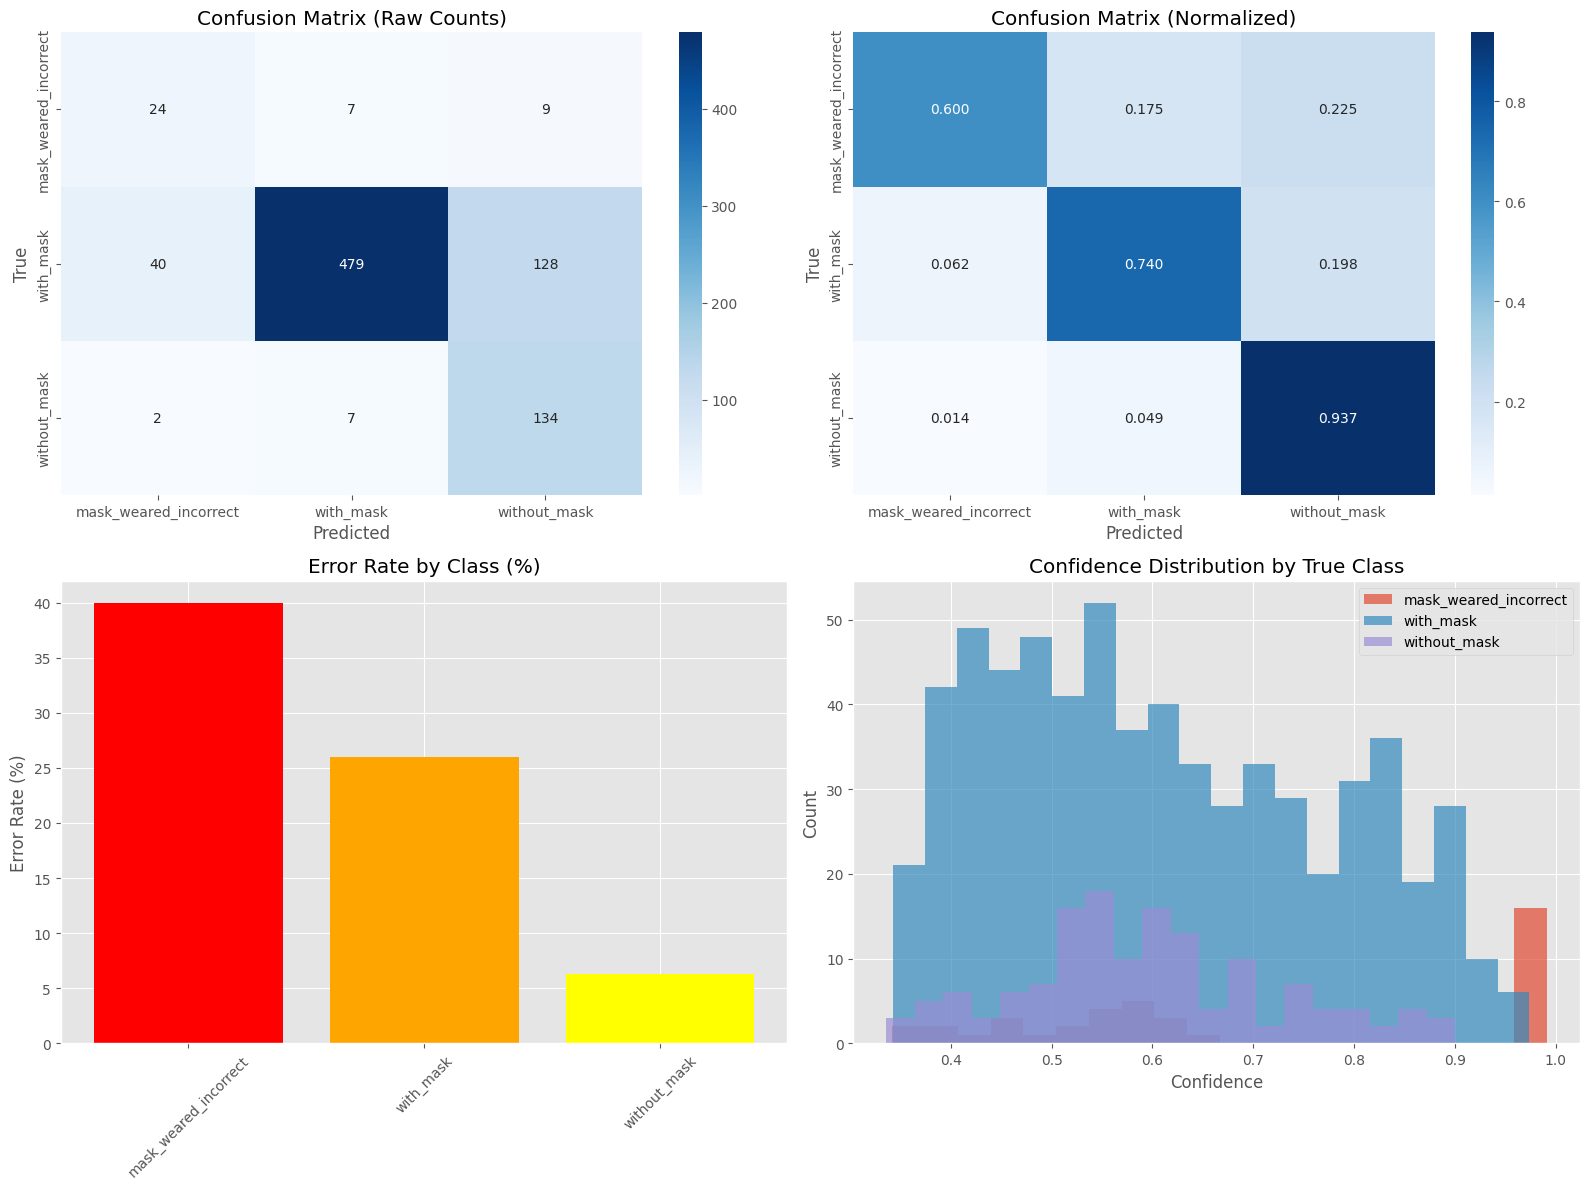


❌ PHÂN TÍCH LỖI CHI TIẾT:
────────────────────────────────────────────────────────────
📊 Tổng số lỗi: 193/830 (23.25%)

🔍 Các loại lỗi phổ biến:
   • with_mask → without_mask: 128 cases (15.42%)
   • with_mask → mask_weared_incorrect: 40 cases (4.82%)
   • mask_weared_incorrect → without_mask: 9 cases (1.08%)
   • mask_weared_incorrect → with_mask: 7 cases (0.84%)
   • without_mask → with_mask: 7 cases (0.84%)
   • without_mask → mask_weared_incorrect: 2 cases (0.24%)


In [26]:
def plot_confusion_matrix_and_errors(test_true_classes, test_pred_classes):
    """Vẽ confusion matrix và phân tích lỗi"""

    # Confusion Matrix
    cm = confusion_matrix(test_true_classes, test_pred_classes)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Raw confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=lb.classes_, yticklabels=lb.classes_,
                ax=axes[0,0])
    axes[0,0].set_title('Confusion Matrix (Raw Counts)')
    axes[0,0].set_xlabel('Predicted')
    axes[0,0].set_ylabel('True')

    # Normalized confusion matrix
    sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues',
                xticklabels=lb.classes_, yticklabels=lb.classes_,
                ax=axes[0,1])
    axes[0,1].set_title('Confusion Matrix (Normalized)')
    axes[0,1].set_xlabel('Predicted')
    axes[0,1].set_ylabel('True')

    # Error analysis
    errors = test_true_classes != test_pred_classes
    error_count = np.sum(errors)

    # Error distribution by true class
    error_by_class = []
    for i, class_name in enumerate(lb.classes_):
        class_mask = (test_true_classes == i)
        class_errors = np.sum(errors & class_mask)
        class_total = np.sum(class_mask)
        error_rate = (class_errors / class_total) * 100 if class_total > 0 else 0
        error_by_class.append(error_rate)

    axes[1,0].bar(lb.classes_, error_by_class, color=['red', 'orange', 'yellow'])
    axes[1,0].set_title('Error Rate by Class (%)')
    axes[1,0].set_ylabel('Error Rate (%)')
    axes[1,0].tick_params(axis='x', rotation=45)

    # Confidence distribution by class
    for i, class_name in enumerate(lb.classes_):
        class_mask = (test_true_classes == i)
        class_confidences = np.max(test_preds[class_mask], axis=1)
        axes[1,1].hist(class_confidences, alpha=0.7, label=class_name, bins=20)

    axes[1,1].set_title('Confidence Distribution by True Class')
    axes[1,1].set_xlabel('Confidence')
    axes[1,1].set_ylabel('Count')
    axes[1,1].legend()

    plt.tight_layout()
    plt.show()

    # Print error analysis
    print(f"\n❌ PHÂN TÍCH LỖI CHI TIẾT:")
    print("─"*60)
    print(f"📊 Tổng số lỗi: {error_count}/{len(test_true_classes)} ({error_count/len(test_true_classes)*100:.2f}%)")

    print(f"\n🔍 Các loại lỗi phổ biến:")
    error_types = {}
    for true_idx in range(len(lb.classes_)):
        for pred_idx in range(len(lb.classes_)):
            if true_idx != pred_idx:
                error_mask = (test_true_classes == true_idx) & (test_pred_classes == pred_idx)
                error_count_type = np.sum(error_mask)
                if error_count_type > 0:
                    error_types[f"{lb.classes_[true_idx]} → {lb.classes_[pred_idx]}"] = error_count_type

    # Sort by error count
    sorted_errors = sorted(error_types.items(), key=lambda x: x[1], reverse=True)
    for error_type, count in sorted_errors:
        percentage = (count / len(test_true_classes)) * 100
        print(f"   • {error_type}: {count} cases ({percentage:.2f}%)")

    return cm, error_by_class

# Chạy confusion matrix analysis
cm, error_rates = plot_confusion_matrix_and_errors(test_true_classes, test_pred_classes)

🎲 Random samples từ test set:

🖼️ HIỂN THỊ 12 SAMPLE PREDICTIONS
────────────────────────────────────────────────────────────

📸 Sample 1 (Index: 463):
   • True class: mask_weared_incorrect
   • Predicted: mask_weared_incorrect (53.9%)
   • Status: ✅ CORRECT
   • All probabilities:
     🎯 mask_weared_incorrect: 53.86%
        with_mask: 44.60%
        without_mask: 1.54%

📸 Sample 2 (Index: 566):
   • True class: with_mask
   • Predicted: with_mask (76.3%)
   • Status: ✅ CORRECT
   • All probabilities:
     🎯 with_mask: 76.26%
        mask_weared_incorrect: 18.95%
        without_mask: 4.78%

📸 Sample 3 (Index: 584):
   • True class: with_mask
   • Predicted: with_mask (53.5%)
   • Status: ✅ CORRECT
   • All probabilities:
     🎯 with_mask: 53.48%
        mask_weared_incorrect: 25.88%
        without_mask: 20.64%

📸 Sample 4 (Index: 612):
   • True class: without_mask
   • Predicted: without_mask (37.8%)
   • Status: ✅ CORRECT
   • All probabilities:
     🎯 without_mask: 37.78%
      

<ipython-input-27-2977445527>:102: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-27-2977445527>:102: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


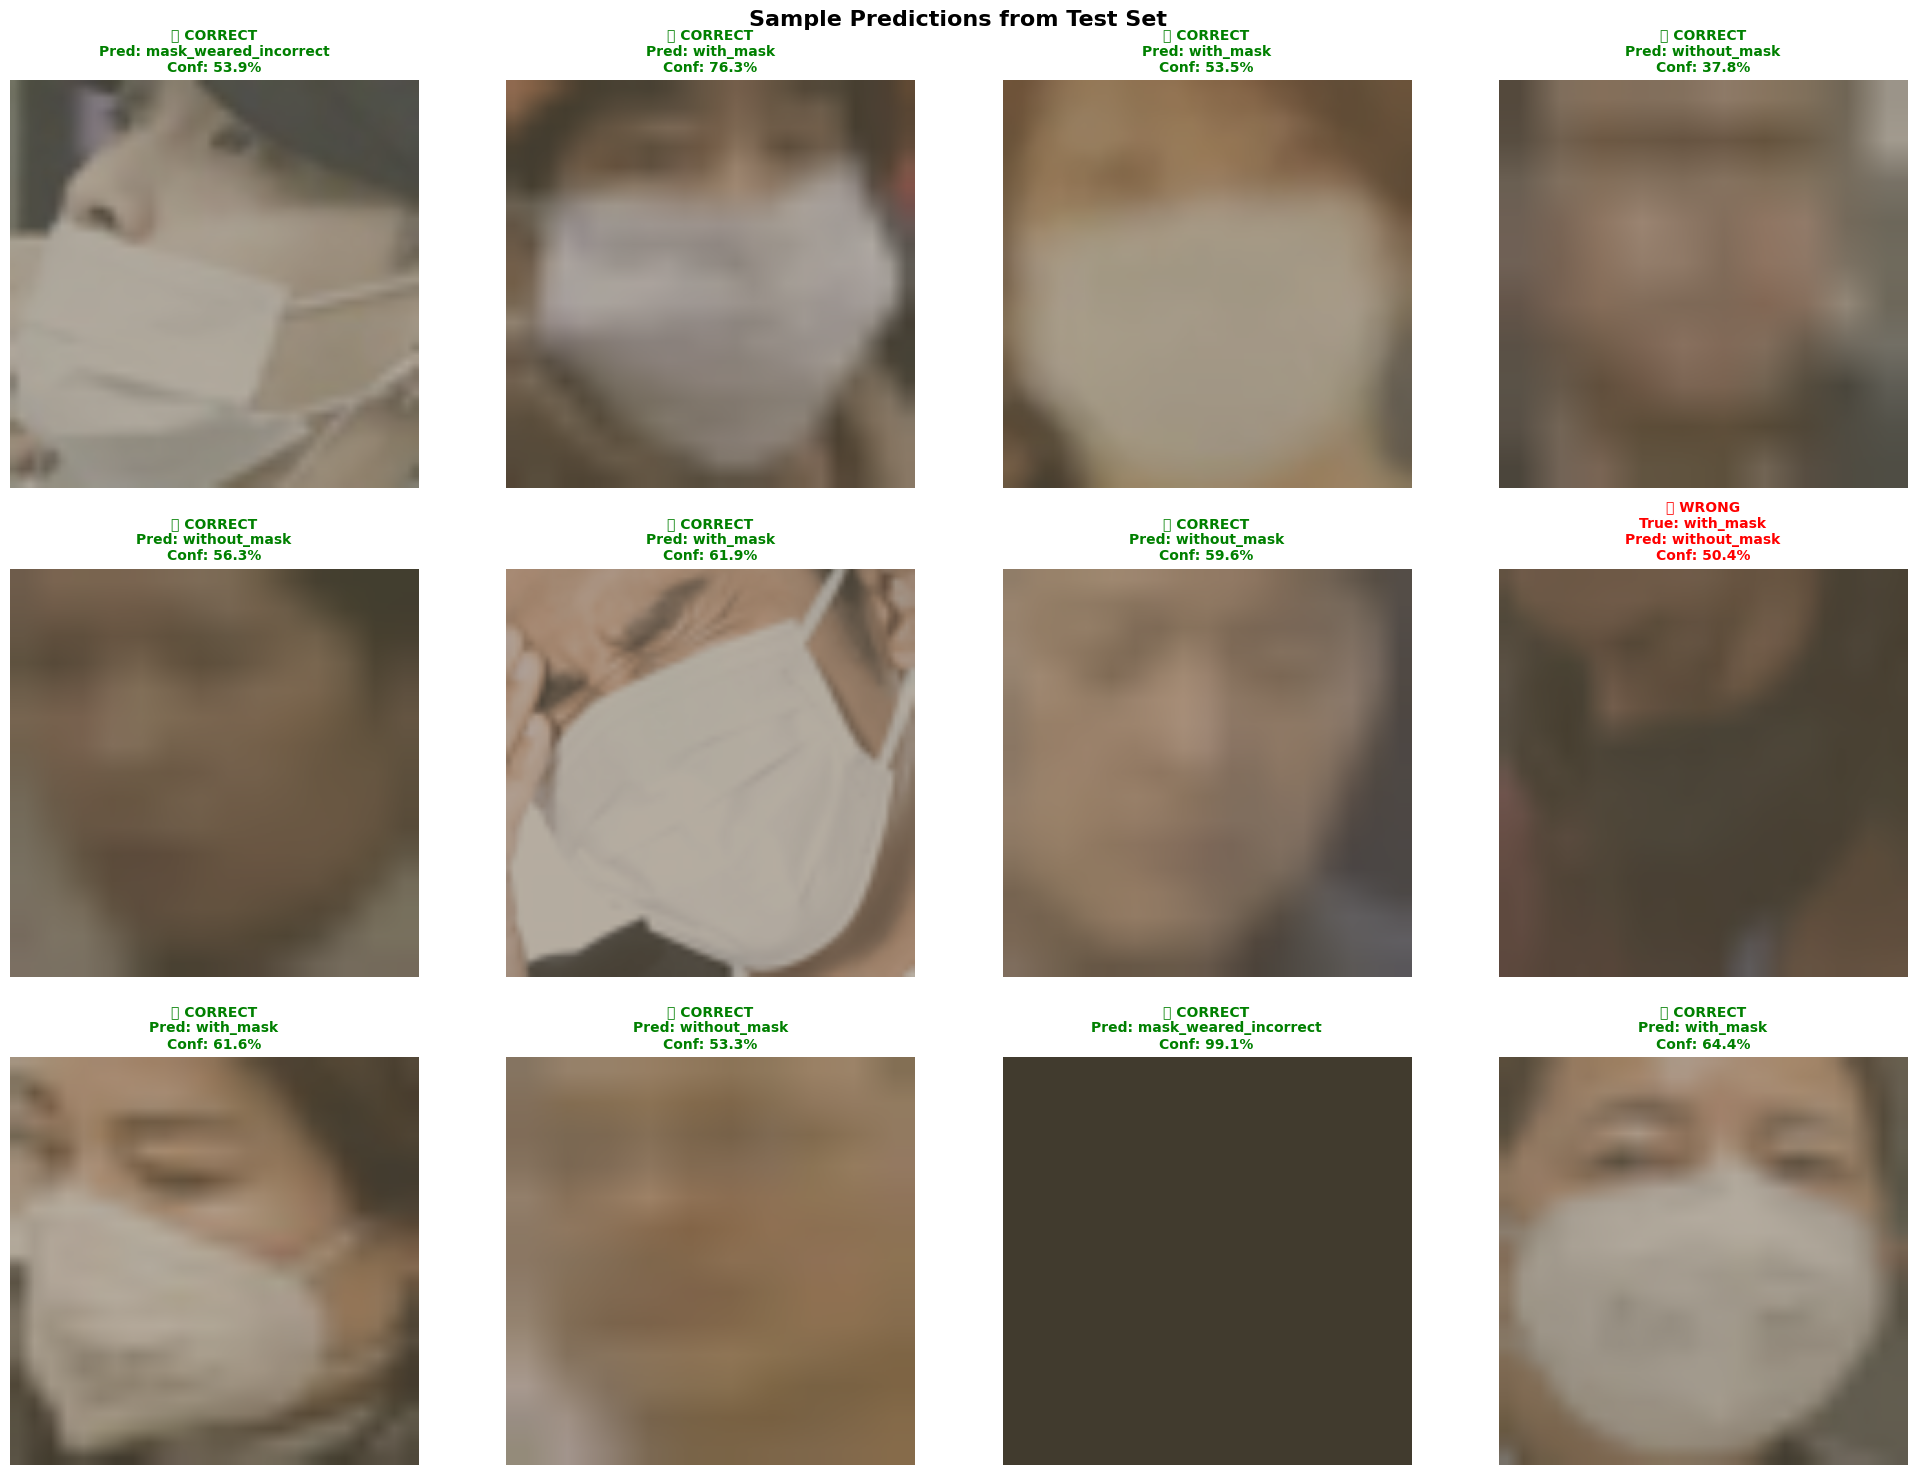


❌ Chỉ những predictions sai:

🖼️ HIỂN THỊ 8 SAMPLE PREDICTIONS
────────────────────────────────────────────────────────────

📸 Sample 1 (Index: 664):
   • True class: with_mask
   • Predicted: without_mask (46.2%)
   • Status: ❌ WRONG
   • All probabilities:
     🎯 without_mask: 46.17%
        with_mask: 41.39%
        mask_weared_incorrect: 12.44%

📸 Sample 2 (Index: 318):
   • True class: without_mask
   • Predicted: with_mask (40.7%)
   • Status: ❌ WRONG
   • All probabilities:
     🎯 with_mask: 40.66%
        mask_weared_incorrect: 31.53%
        without_mask: 27.81%

📸 Sample 3 (Index: 238):
   • True class: with_mask
   • Predicted: without_mask (46.1%)
   • Status: ❌ WRONG
   • All probabilities:
     🎯 without_mask: 46.14%
        mask_weared_incorrect: 27.03%
        with_mask: 26.83%

📸 Sample 4 (Index: 67):
   • True class: with_mask
   • Predicted: without_mask (47.4%)
   • Status: ❌ WRONG
   • All probabilities:
     🎯 without_mask: 47.38%
        mask_weared_incorrect: 2

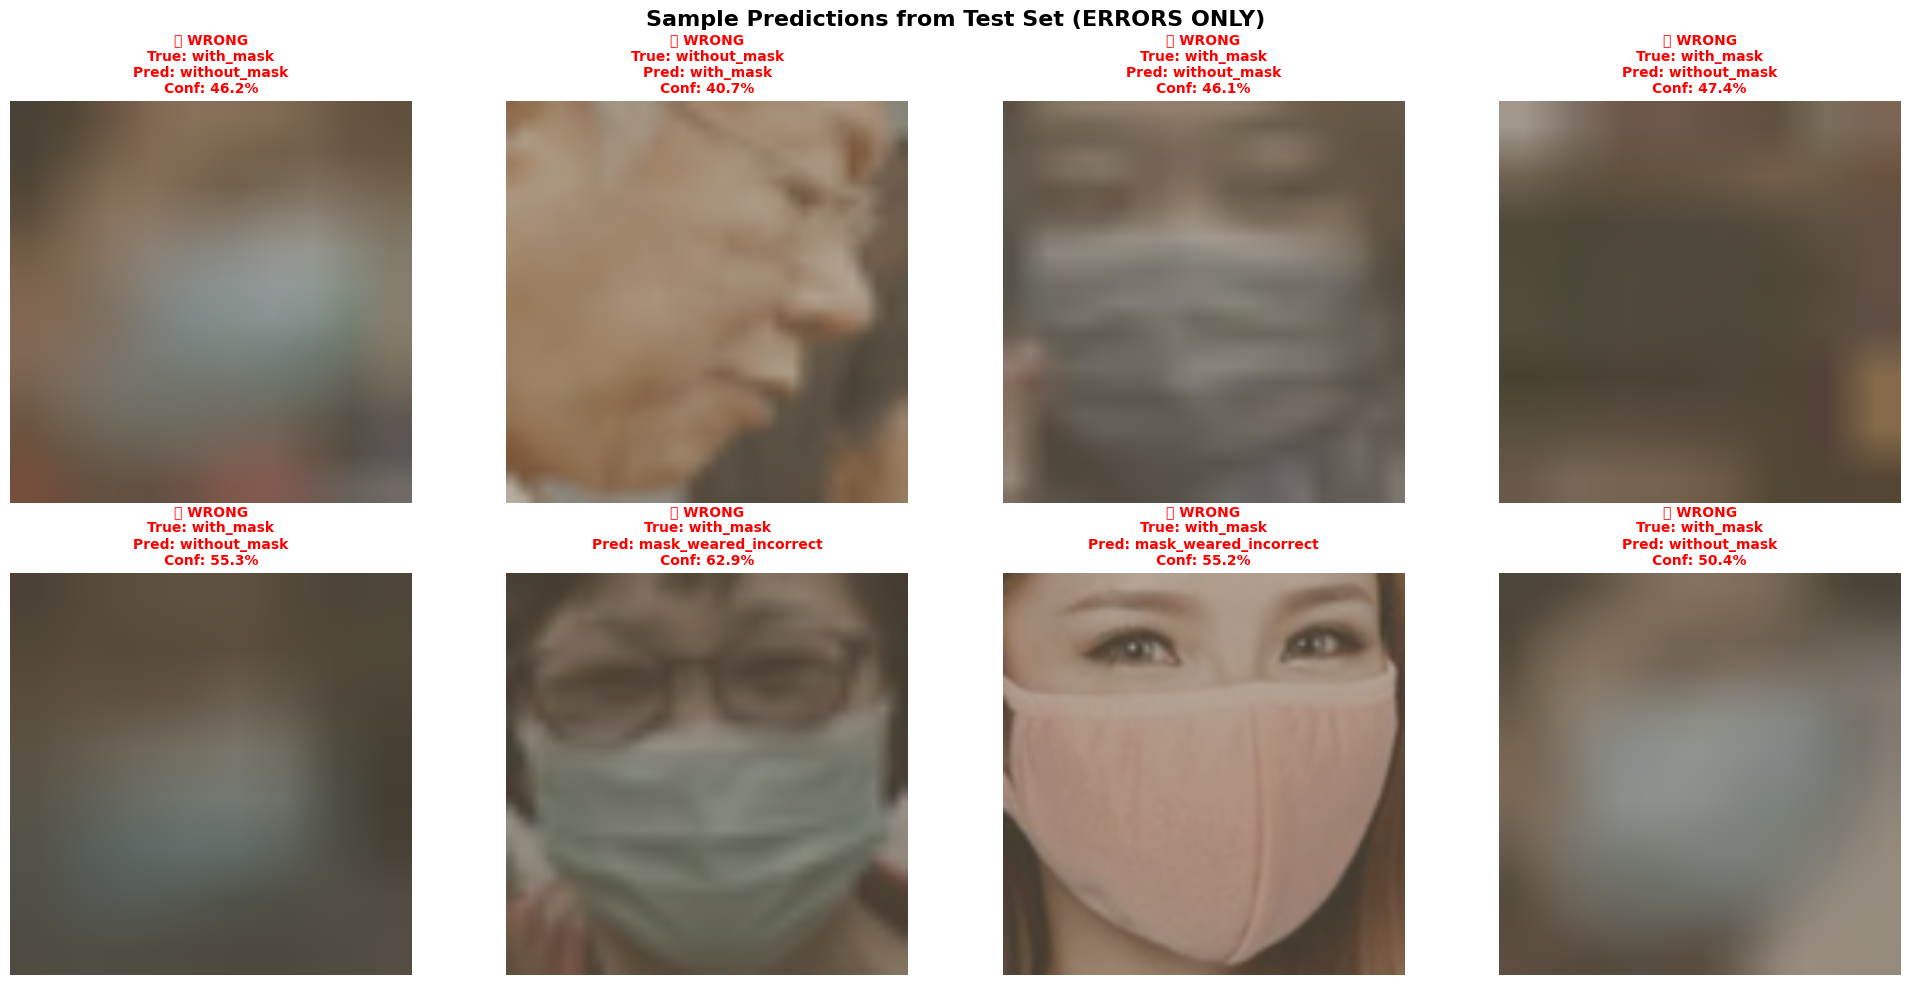

In [27]:
def visualize_sample_predictions(n_samples=12, show_errors_only=False):
    """Hiển thị sample predictions với detailed analysis"""

    print(f"\n🖼️ HIỂN THỊ {n_samples} SAMPLE PREDICTIONS")
    print("─"*60)

    if show_errors_only:
        # Chỉ hiển thị những predictions sai
        error_mask = test_true_classes != test_pred_classes
        error_indices = np.where(error_mask)[0]

        if len(error_indices) == 0:
            print("✅ Không có lỗi prediction nào để hiển thị!")
            return

        sample_indices = np.random.choice(error_indices,
                                        min(n_samples, len(error_indices)),
                                        replace=False)
        title_suffix = " (ERRORS ONLY)"
    else:
        # Random samples từ toàn bộ test set
        sample_indices = np.random.choice(len(testX), n_samples, replace=False)
        title_suffix = ""

    # Calculate grid size
    cols = 4
    rows = (n_samples + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(20, 5*rows))
    if rows == 1:
        axes = axes.reshape(1, -1)

    for i, idx in enumerate(sample_indices):
        row = i // cols
        col = i % cols

        if rows == 1:
            ax = axes[col]
        else:
            ax = axes[row, col]

        # Get image and predictions
        image = testX[idx]
        true_class_idx = test_true_classes[idx]
        pred_class_idx = test_pred_classes[idx]
        pred_probs = test_preds[idx]

        true_class = lb.classes_[true_class_idx]
        pred_class = lb.classes_[pred_class_idx]
        confidence = pred_probs[pred_class_idx] * 100

        # Denormalize image for display
        img_display = image.copy()

        # Reverse preprocessing if needed
        # Assuming the image was preprocessed with preprocess_input
        img_display = (img_display * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
        img_display = np.clip(img_display, 0, 1)

        # Display image
        ax.imshow(img_display)

        # Create title with prediction info
        if true_class_idx == pred_class_idx:
            title_color = 'green'
            status = "✅ CORRECT"
            title = f"{status}\nPred: {pred_class}\nConf: {confidence:.1f}%"
        else:
            title_color = 'red'
            status = "❌ WRONG"
            title = f"{status}\nTrue: {true_class}\nPred: {pred_class}\nConf: {confidence:.1f}%"

        ax.set_title(title, color=title_color, fontsize=10, fontweight='bold')
        ax.axis('off')

        # Print detailed info
        print(f"\n📸 Sample {i+1} (Index: {idx}):")
        print(f"   • True class: {true_class}")
        print(f"   • Predicted: {pred_class} ({confidence:.1f}%)")
        print(f"   • Status: {status}")
        print(f"   • All probabilities:")

        # Sort probabilities
        prob_pairs = [(lb.classes_[j], pred_probs[j]*100) for j in range(len(lb.classes_))]
        prob_pairs.sort(key=lambda x: x[1], reverse=True)

        for class_name, prob in prob_pairs:
            icon = "🎯" if class_name == pred_class else "  "
            print(f"     {icon} {class_name}: {prob:.2f}%")

    # Hide empty subplots
    total_plots = rows * cols
    for i in range(n_samples, total_plots):
        row = i // cols
        col = i % cols
        if rows == 1:
            axes[col].axis('off')
        else:
            axes[row, col].axis('off')

    plt.suptitle(f'Sample Predictions from Test Set{title_suffix}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Hiển thị random samples
print("🎲 Random samples từ test set:")
visualize_sample_predictions(n_samples=12, show_errors_only=False)

# Hiển thị chỉ những lỗi
print("\n❌ Chỉ những predictions sai:")
visualize_sample_predictions(n_samples=8, show_errors_only=True)

In [28]:
def generate_performance_summary(detailed_results, cm, error_rates):
    """Tạo báo cáo tổng kết và khuyến nghị"""

    print("\n" + "🏆"*60)
    print("📋 BÁO CÁO TỔNG KẾT HIỆU SUẤT MODEL")
    print("🏆"*60)
    print(f"📅 Ngày đánh giá: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"👤 Người đánh giá: strawberrymilktea0604")
    print(f"🤖 Model: SSD-MobileNetV2 Face Mask Detection")

    # Overall Performance
    overall_acc = detailed_results['overall_accuracy']
    print(f"\n🎯 HIỆU SUẤT TỔNG QUAN:")
    print(f"   • Độ chính xác tổng thể: {overall_acc:.4f} ({overall_acc*100:.2f}%)")

    # Performance by class
    class_metrics = detailed_results['class_metrics']
    avg_precision = np.mean(class_metrics['precision'])
    avg_recall = np.mean(class_metrics['recall'])
    avg_f1 = np.mean(class_metrics['f1'])

    print(f"   • Precision trung bình: {avg_precision:.4f}")
    print(f"   • Recall trung bình: {avg_recall:.4f}")
    print(f"   • F1-Score trung bình: {avg_f1:.4f}")

    # Confidence stats
    conf_stats = detailed_results['confidence_stats']
    print(f"   • Độ tin cậy trung bình: {conf_stats['avg']:.4f} ({conf_stats['avg']*100:.2f}%)")

    # Performance rating
    print(f"\n⭐ ĐÁNH GIÁ TỔNG THỂ:")
    if overall_acc >= 0.95:
        rating = "🌟 XUẤT SẮC"
        description = "Model có hiệu suất rất cao, phù hợp cho production"
    elif overall_acc >= 0.90:
        rating = "✅ RẤT TỐT"
        description = "Model có hiệu suất tốt, có thể sử dụng thực tế"
    elif overall_acc >= 0.85:
        rating = "👍 TỐT"
        description = "Model có hiệu suất chấp nhận được"
    elif overall_acc >= 0.80:
        rating = "⚠️ TRUNG BÌNH"
        description = "Model cần cải thiện trước khi triển khai"
    else:
        rating = "❌ CẦN CẢI THIỆN"
        description = "Model cần training lại hoặc cải thiện architecture"

    print(f"   {rating}: {description}")

    # Detailed class analysis
    print(f"\n📊 PHÂN TÍCH CHI TIẾT THEO CLASS:")
    best_class = np.argmax(class_metrics['class_accuracies'])
    worst_class = np.argmin(class_metrics['class_accuracies'])

    print(f"   • Class tốt nhất: {lb.classes_[best_class]} ({class_metrics['class_accuracies'][best_class]*100:.2f}%)")
    print(f"   • Class cần cải thiện: {lb.classes_[worst_class]} ({class_metrics['class_accuracies'][worst_class]*100:.2f}%)")

    # Problem identification
    print(f"\n🔍 NHẬN DIỆN VẤN ĐỀ:")
    problems = []

    if conf_stats['avg'] < 0.8:
        problems.append("Độ tin cậy prediction thấp")

    if np.std(class_metrics['class_accuracies']) > 0.1:
        problems.append("Hiệu suất không đồng đều giữa các class")

    if class_metrics['class_accuracies'][worst_class] < 0.7:
        problems.append(f"Class '{lb.classes_[worst_class]}' có hiệu suất thấp")

    low_conf_count = np.sum(np.max(test_preds, axis=1) < 0.7)
    if low_conf_count > len(test_preds) * 0.1:
        problems.append("Nhiều predictions có độ tin cậy thấp")

    if problems:
        for i, problem in enumerate(problems, 1):
            print(f"   {i}. {problem}")
    else:
        print("   ✅ Không phát hiện vấn đề lớn nào")

    # Recommendations
    print(f"\n💡 KHUYẾN NGHỊ CẢI THIỆN:")

    recommendations = []

    if overall_acc < 0.90:
        recommendations.append("Thu thập thêm dữ liệu training")
        recommendations.append("Thử các architecture model khác")
        recommendations.append("Fine-tuning hyperparameters")

    if class_metrics['class_accuracies'][worst_class] < 0.8:
        recommendations.append(f"Data augmentation cho class '{lb.classes_[worst_class]}'")
        recommendations.append("Cân bằng dataset với class weights")

    if conf_stats['avg'] < 0.8:
        recommendations.append("Ensemble methods để tăng độ tin cậy")
        recommendations.append("Temperature scaling cho calibration")

    if conf_stats['std'] > 0.2:
        recommendations.append("Regularization để giảm overfitting")

    # Add specific recommendations based on mask detection task
    recommendations.extend([
        "Thu thập dữ liệu đa dạng về góc chụp và điều kiện ánh sáng",
        "Tăng cường data với các loại khẩu trang khác nhau",
        "Test với real-world deployment scenarios"
    ])

    for i, rec in enumerate(recommendations[:8], 1):  # Limit to top 8
        print(f"   {i}. {rec}")

    # Deployment readiness
    print(f"\n🚀 KHUYẾN NGHỊ TRIỂN KHAI:")

    if overall_acc >= 0.90 and conf_stats['avg'] >= 0.8:
        deployment_status = "✅ SẴN SÀNG"
        deployment_note = "Model có thể triển khai production với monitoring"
    elif overall_acc >= 0.85:
        deployment_status = "⚠️ CẦN THẬN TRỌNG"
        deployment_note = "Có thể triển khai thử nghiệm với giám sát chặt chẽ"
    else:
        deployment_status = "❌ CHƯA SẴN SÀNG"
        deployment_note = "Cần cải thiện model trước khi triển khai"

    print(f"   • Trạng thái: {deployment_status}")
    print(f"   • Ghi chú: {deployment_note}")

    print("\n" + "🏆"*60)

    # Save summary to dict for further use
    summary = {
        'overall_accuracy': overall_acc,
        'rating': rating,
        'best_class': lb.classes_[best_class],
        'worst_class': lb.classes_[worst_class],
        'deployment_ready': overall_acc >= 0.90 and conf_stats['avg'] >= 0.8,
        'problems': problems,
        'recommendations': recommendations
    }

    return summary

# Tạo báo cáo tổng kết
final_summary = generate_performance_summary(detailed_results, cm, error_rates)

# Lưu kết quả vào file (optional)
import json

evaluation_report = {
    'timestamp': datetime.now().isoformat(),
    'evaluator': 'strawberrymilktea0604',
    'model_type': 'SSD-MobileNetV2',
    'test_set_size': len(testX),
    'overall_accuracy': float(detailed_results['overall_accuracy']),
    'class_metrics': {
        'precision': [float(x) for x in detailed_results['class_metrics']['precision']],
        'recall': [float(x) for x in detailed_results['class_metrics']['recall']],
        'f1': [float(x) for x in detailed_results['class_metrics']['f1']],
        'support': [int(x) for x in detailed_results['class_metrics']['support']]
    },
    'confidence_stats': {k: float(v) for k, v in detailed_results['confidence_stats'].items()},
    'summary': final_summary
}

# Save to JSON file
with open('mask_detection_evaluation_report.json', 'w') as f:
    json.dump(evaluation_report, f, indent=2)

print(f"\n💾 Báo cáo đã được lưu vào: mask_detection_evaluation_report.json")


🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆
📋 BÁO CÁO TỔNG KẾT HIỆU SUẤT MODEL
🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆
📅 Ngày đánh giá: 2025-06-13 09:40:33
👤 Người đánh giá: strawberrymilktea0604
🤖 Model: SSD-MobileNetV2 Face Mask Detection

🎯 HIỆU SUẤT TỔNG QUAN:
   • Độ chính xác tổng thể: 0.7675 (76.75%)
   • Precision trung bình: 0.6099
   • Recall trung bình: 0.7591
   • F1-Score trung bình: 0.6468
   • Độ tin cậy trung bình: 0.6122 (61.22%)

⭐ ĐÁNH GIÁ TỔNG THỂ:
   ❌ CẦN CẢI THIỆN: Model cần training lại hoặc cải thiện architecture

📊 PHÂN TÍCH CHI TIẾT THEO CLASS:
   • Class tốt nhất: without_mask (93.71%)
   • Class cần cải thiện: mask_weared_incorrect (60.00%)

🔍 NHẬN DIỆN VẤN ĐỀ:
   1. Độ tin cậy prediction thấp
   2. Hiệu suất không đồng đều giữa các class
   3. Class 'mask_weared_incorrect' có hiệu suất thấp
   4. Nhiều predictions có độ tin cậy thấp

💡 KHUYẾN NGHỊ CẢI THIỆN:
   1. Thu thập thêm dữ liệu training
   2. Thử các architect